In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# Index
1. [Imports](#Imports)
1. [CTEPG](#CTEPG-(Catching-The-Elusive-Predictable-Genes)-15-06-2020---22-06-2020)
1. [Dyslipid database creation](#Creating-dyslipid-dataset)
1. [Model 1 overviews (only run when xgboost 0.72.1 is installed)](#Model-1.0-statistics)
1. [New 2.0 models](#2.0-Base-models)
1. [Model 2.0 without bugs](#Actual-correct-2.0-model-without-bugs.)
1. [Original model](#Original-model)
1. [Cross validated models](#CV-Models)
1. [XGB models out of CV models](#New-Models)
1. [Mismatch analysis](#Mismatch-analysis)
1. [AUC analysis base model](#Full-dataset-AUC-analysis)
1. [Preparing data for Cardiovascular model](#Preparing-training-data-for-Cardiovascular)
1. [Preparing data for Dyslipid model](#Preparing-data-for-Dyslipid.)
1. [Preparing data for Neurogenetica model](#Preparing-data-for-Neurogenetics.)
1. [Preparing data for Hereditary cancer model](#Preparing-data-for-Hereditary-cancer)
1. [AUC analysis specific models](#AUC-analysis-on-Specific-models)
1. [AUC of specific panels on specific models vs number of samples analysis](#AUC-vs-n_samples-analysis)
1. [Model on best performing panel, preparation](#Model-on-best-performing-panel,-prepartation)
1. [Barplot of type of variants for each panel](#Barplot-of-type-of-variants-for-each-panel)

# Imports

In [1]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pickle
from utilities import get_header, genepanel_analysis, auc_analysis_function
from utilities import analyze_auc_per_gene, correct_threshold, read_capice_output
from utilities import full_auc_analysis
from sklearn.metrics import recall_score, precision_score, f1_score
from pathlib import Path
import subprocess
from sklearn.metrics import roc_auc_score
from bokeh.palettes import viridis

# Defining some import and export locations
location = 'rjsietsma'
read_loc = '/home/'+location+'/shared/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'
img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

with open('./umcg_genepanels.json', 'r') as panels:
    genepanels = json.load(panels)
    genepanels.pop('5GPM', None)

 # CTEPG (Catching The Elusive Predictable Genes) 15-06-2020 - 22-06-2020
 [Index](#Index)
<br/><br/>

What have I done:

- Made plot of Panel vs all combined:
![Panel vs all combined](img/allvs1boxplot_umcggenepanels.png)

- Issued [pull request](https://github.com/molgenis/capice/pull/1) for Dennis and Bart to be able to work with CAPICE locally.
- Refactored CAPICE code _(not finished)_.
- Retrained new models.
- Found new Pathogenic / Benign threshold within CAPICE.
- Made fancy new notebook with [indexing](#Index).



Planned for this week:
- Make barplot of type of variants for each panel.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Rebuild benchmarking dataset to the full dataset in Initial Data Exploration.
- Model refinement:
    - AUC analysis of new model (model xgb_booster37.pickle.dat)
    - Check for improvements.
    - Then split the training / testing data in the different models. (xgb_booster37.pickle.dat and xgb_booster_dyslipid.pickle.dat)
        - Also do the full dataset on dyslipid. Do not try to split the data into the 2 models. 
        - Try to build new models on average performing and well performing panels aswell, try to see if everything improves nicely.
            - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
        - _Note: Shuang her data has almost half the variants than the newer VGKL and Clinvar datasets, with 3913 benign and 1116 malignant samples._
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Dyslipid and Erfelijke kanker
- AUC analysis of dyslipid panel
    - Interestingly: it performs only SLIGHTLY better than the 2.0 base model:
<br/><br/>

AUC 2.0 base:

- Test: 0.7743036340158642
- Train: 0.9822742260567594

AUC 2.0 Dyslipid:

- Test: 0.7770706511713705
- Train: 0.9827123551221991
<br/><br/>

    - Note: AUC analysis is performed with an updated threshold, see the correct_threshold function.
    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- ~Make barplot of type of variants for each panel.~
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Base 2.0, Dyslipid
    - End AUC base: validation_0-auc:0.97662
    - End AUC dyslipid: validation_0-auc:0.98676
- [Make barplot of type of variants for each panel.]()

    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 06-07-2020 - 13-07-2020
[Index](#Index)
<br/><br/>

Planned for this week:
- Investigate whenever [github](https://github.com/molgenis/capice) model is up to date with the GCC cluster model.
- Add select_balanced_benign_dataset function in train_model.py
    - See step4_xgboost_finetune....py, line 20-65 for more details.
    - Also export this dataset that it makes for validation.
- Recheck all AUC analysis that I did.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 06-07-2020 - 13-07-2020
[Index](#Index)
<br/><br/>

Planned for this week:
- ~Recheck AUC analysis of model 1.0.~
- ~Make Mann-Whitney plots more readable, including the mean and STD of the genepanels.~
- ~Make scatterplot of AUC vs number of variants in genepanels.~
    - ~Do the same for AUC vs number of pathogenic variants.~
    - ~Same for AUC vs number of benign variants.~
- Make model for each gene panel, not rely-ing on the amount of variants within that panel, see what amount of variants is at least required to see improvements. Do this for balanced and unbalanced.
- Make specific models for
    - 1: Bad performing panel (Hart- en vaatziekten)
    - 2: Well performing panel (Neurogenetica)
    - 3: Average performing panel (random)
        - Make these specific models with an unbalanced and balanced dataset and see what is really required for these panels and models to perform better.
- Investigate overlapping genes within the genepanels.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
    
(Discussable to continue with)

- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 03-08-2020 - 10-08-2020
[Index](#Index)
<br/><br/>

Done:
- Checked the enrichr AUC data that the correct column was used.
- Decided on the various specific models.
    - Cardiovascular as worst.
    - Dyslipid aswell.
    - Neurogenetics as best.
    - Hereditary cancer as average.
 - Made models for:
     - Specific models mentioned above, both balanced and unbalanced.
     - Specific models mentioned above but with cross validated hyperparameters.
 
 
##### Intermediate results:

Model 1.0:

- train: 0.9972
- test: 0.8936
- Genepanel mean: 0.9909
- n: ?

Base balanced:

- train: 0.9664
- test: 0.9394
- Genepanel mean: 0.9331
- n: 51882

Base unbalanced:

- train: 0.9972
- test: 0.8937
- Genepanel mean: 0.9911
- n: 334601
 
Cardiovascular balanced: 

- Train: 0.7853
- Test: 0.6612
- Genepanel mean: 0.8159
- n: 8296

Cardiovascular unbalanced:

- Train: 0.9166
- Test: 0.6586
- Genepanel mean: 0.9237
- n: 35058

Dyslipid balanced:

- Trian: 0.6635
- Test: 0.5742
- Genepanel mean: 0.6679
- n: 1530

Dyslipid unbalanced:

- Train: 0.8354
- Test: 0.5907
- Genepanel mean: 0.8646
- n: 5029

Hereditary cancer balanced:

- Train: 0.7876
- Test: 0.7325
- Genepanel mean: 0.8021
- n: 3442

Hereditary cancer unbalanced:

- Train: 0.9413
- Test: 0.6888
- Genepanel mean: 0.9411
- n: 26776

Neurogenetics balanced:

- Train: 0.8092
- Test: 0.7111
- Genepanel mean: 0.8228
- n: 7196

Neurogenetics unbalanced:

- Train: 0.9481
- Test: 0.6843
- Genepanel mean: 0.9419
- n: 29769

Optimal Hyperparameters:

- Base balanced:
  - learning_rate = 0.09666968094405538
  - n_estimators = 563
  - max_depth = 11
  - train = 0.9659
  - test = 0.9441
  - Genepanel mean: 0.9312
  - n: 51882
- Base unbalanced:
  - learning_rate = 0.3313738741131076
  - n_estimators = 300
  - max_depth = 13
  - train = 0.9971
  - test = 0.9001
  - Genepanel mean: 0.9901
  - n: 334601
- Cardiovascular balanced:
  - learning_rate = 0.06319721082589663
  - n_estimators = 200
  - max_depth = 19
  - train = 0.7802
  - test = 0.6584
  - Genepanel mean: 0.8025
  - n: 8296
- Cardiovascular unbalanced:
  - learning_rate = 0.09123613810475494
  - n_estimators = 424
  - max_depth = 16
  - train = 0.9166
  - test = 0.6567
  - Genepanel mean: 0.9245
  - n: 35058
- Dyslipid balanced:
  - learning_rate = 0.1527244637312314
  - n_estimators = 211
  - max_depth = 10
  - train = 0.7188
  - test = 0.5654
  - Genepanel mean: 0.7729
  - n: 1530
- Dyslipid unbalanced:
  - learning_rate = 0.15442510030625153
  - n_estimators = 257
  - max_depth = 17
  - train = 0.8429
  - test = 0.5908
  - Genepanel mean: 0.8685
  - n: 5029
- Hereditary cancer balanced:
  - learning_rate = 0.10027603273002453
  - n_estimators = 268
  - max_depth = 9
  - train = 0.7802
  - test = 0.7311
  - Genepanel mean: 0.7914
  - n: 3442
- Hereditary cancer unbalanced:
  - learning_rate = 0.08919100783998443
  - n_estimators = 402
  - max_depth = 15
  - train = 0.9411
  - test = 0.6906
  - Genepanel mean: 0.9399
  - n: 26776
- Neurogenetics balanced:
  - learning_rate = 0.06842042925150449
  - n_estimators = 341
  - max_depth = 10
  - train = 0.8133
  - test = 0.7147
  - Genepanel mean: 0.8287
  - n: 7196
- Neurogenetics unbalanced:
  - learning_rate = 0.07430969057642688
  - n_estimators = 466
  - max_depth = 7
  - train = 0.9465
  - test = 0.6948
  - Genepanel mean: 0.9414
  - n: 29769

__Verdict: Unbalanced performs seemingly better in specific models, but overfits. In balanced, both the train and test AUC are not great. The winner of default hyperparameters for a balanced learning dataset is Neurogenetics, the winner of the unbalanced dataset is also Neurogenetics, indicating that a well performing panel could be used as a template for the entire genome.__


Planned for this week:
- ~Make model for each gene panel, not rely-ing on the amount of variants within that panel, see what amount of variants is at least required to see improvements. Do this for balanced and unbalanced.~
- ~Make specific models for~
    - ~1: Bad performing panel (Hart- en vaatziekten)~
    - ~2: Well performing panel (Neurogenetica)~
    - ~3: Average performing panel (random)~
        - ~Make these specific models with an unbalanced and balanced dataset and see what is really required for these panels and models to perform better.~
- Write report.
- Fix results of specific models, apart from dyslipid model.
    - Train, test split (90/10)
    - Train on train
    - AUC calculation on test
    - Make train smaller by x%
    - Train on smaller train
    - AUC calculation on test
    - __Repeat__
- Investigate overlapping genes within the genepanels.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
    
(Discussable to continue with)

- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# Creating dyslipid dataset
[Index](#Index)

In [7]:
file_loc = os.path.join(read_loc, 'train.txt.gz')
header = get_header(file_loc, '#Chrom')
train = pd.read_csv(file_loc, compression='gzip', names=header, comment='#', sep='\t', low_memory=False)
train

#Chrom  Allergy/Immunology/Infectious Alt          AnnoType  \
0          14                          False   G  CodingTranscript   
1          20                          False   T  CodingTranscript   
2          20                          False   C  CodingTranscript   
3          20                          False   A  CodingTranscript   
4          20                          False   A        Intergenic   
...       ...                            ...  ..               ...   
334596     17                          False   A  CodingTranscript   
334597     17                          False   T  CodingTranscript   
334598     10                          False   T  CodingTranscript   
334599      2                          False   T  CodingTranscript   
334600      5                          False   T  CodingTranscript   

        Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
0                            False        False   CCDS9787.1   806.0   
1                             True        False  CCDS13112.1  1899.0   
2                             True        False  CCDS13112.1  2118.0   
3                             True        False  CCDS13112.1  1586.0   
4                             True        False          NaN     NaN   
...                            ...          ...          ...     ...   
334596                       False        False  CCDS32642.1  1563.0   
334597                       False        False  CCDS32642.1  2029.0   
334598                       False        False   CCDS7431.1  1216.0   
334599                       False        False   CCDS2382.1  2998.0   
334600                       False        False   CCDS3952.1  1221.0   

        Cardiovascular              ConsDetail  ...  revel sift   source  \
0                False              frameshift  ...    NaN  NaN     vkgl   
1                 True  frameshift,stop_gained  ...    NaN  NaN     vkgl   
2                 True              frameshift  ...    NaN  NaN     vkgl   
3                 True              frameshift  ...    NaN  NaN     vkgl   
4                 True              downstream  ...    NaN  NaN     vkgl   
...                ...                     ...  ...    ...  ...      ...   
334596           False             stop_gained  ...    NaN  NaN  unknown   
334597           False             stop_gained  ...    NaN  NaN  unknown   
334598           False             stop_gained  ...    NaN  NaN  unknown   
334599           False             stop_gained  ...    NaN  NaN  unknown   
334600           False             stop_gained  ...    NaN  NaN  unknown   

        tOverlapMotifs  targetScan  to_be_deleted  verPhCons verPhyloP inTest  \
0                  NaN         NaN          False      1.000     5.843  False   
1                  NaN         NaN          False      1.000     4.670  False   
2                  NaN         NaN          False      1.000     5.043  False   
3                  NaN         NaN          False      1.000     6.221  False   
4                  NaN         NaN          False      1.000     6.368  False   
...                ...         ...            ...        ...       ...    ...   
334596             NaN         NaN          False      1.000     6.031  False   
334597             NaN         NaN          False      1.000     4.100  False   
334598             NaN         NaN          False      1.000     5.852  False   
334599             NaN         NaN          False      0.031     2.213  False   
334600             NaN         NaN          False      1.000     0.528  False   

        sample_weight  
0                 1.0  
1                 1.0  
2                 1.0  
3                 1.0  
4                 1.0  
...               ...  
334596            0.8  
334597            0.8  
334598            0.8  
334599            0.8  
334600            0.8  

[334601 rows x 152 columns]

In [8]:
with open('./umcg_genepanels.json', 'r') as json_file:
    genes = json.load(json_file)
dislipid_genes = genes['Hart- en vaatziekten']
genelist = []
for key, value in dislipid_genes.items():
    if key.lower().startswith('dyslipid'):
        for g in value:
            if g not in genelist:
                genelist.append(g)

In [9]:
dislipid_subset = train.loc[train['GeneName'].isin(genelist)]
dislipid_subset

#Chrom  Allergy/Immunology/Infectious                     Alt  \
142        16                          False                       T   
148        19                          False  CCGGCGAGGTGCAGGCCATGCT   
149         2                          False                       C   
150         2                          False                       G   
151         2                          False                       C   
...       ...                            ...                     ...   
334284     12                          False                       T   
334285     12                          False                       A   
334286     12                          False                       T   
334287     12                          False                       G   
334288     12                          False                       G   

                AnnoType  Audiologic/Otolaryngologic  Biochemical  \
142     CodingTranscript                       False        False   
148     CodingTranscript                       False        False   
149     CodingTranscript                       False        False   
150     CodingTranscript                       False        False   
151     CodingTranscript                       False        False   
...                  ...                         ...          ...   
334284  CodingTranscript                       False        False   
334285  CodingTranscript                       False        False   
334286  CodingTranscript                       False        False   
334287  CodingTranscript                       False        False   
334288  CodingTranscript                       False        False   

               CCDS   CDSpos  Cardiovascular        ConsDetail  ...  revel  \
142     CCDS10772.1    848.0            True        frameshift  ...    NaN   
148     CCDS12647.1    409.0            True  protein_altering  ...    NaN   
149      CCDS1703.1  13028.0            True        frameshift  ...    NaN   
150      CCDS1703.1     28.0            True        frameshift  ...    NaN   
151      CCDS1703.1   2534.0            True        frameshift  ...    NaN   
...             ...      ...             ...               ...  ...    ...   
334284   CCDS8685.1   1093.0           False       stop_gained  ...    NaN   
334285   CCDS8685.1   1475.0           False       stop_gained  ...    NaN   
334286   CCDS8685.1   1537.0           False       stop_gained  ...    NaN   
334287   CCDS8685.1   1553.0           False       stop_gained  ...    NaN   
334288   CCDS8685.1   1634.0           False       stop_gained  ...    NaN   

       sift   source  tOverlapMotifs  targetScan  to_be_deleted  verPhCons  \
142     NaN     vkgl             NaN         NaN          False      0.928   
148     NaN     vkgl             NaN         NaN           True      0.863   
149     NaN     vkgl             NaN         NaN          False      0.000   
150     NaN     vkgl             NaN         NaN          False      0.021   
151     NaN     vkgl             NaN         NaN          False      0.653   
...     ...      ...             ...         ...            ...        ...   
334284  NaN  unknown             NaN         NaN          False      0.999   
334285  NaN  unknown             NaN         NaN          False      0.580   
334286  NaN  unknown             NaN         NaN          False      0.003   
334287  NaN  unknown             NaN         NaN          False      0.510   
334288  NaN  unknown             NaN         NaN          False      0.000   

       verPhyloP inTest  sample_weight  
142        2.614  False            1.0  
148        0.839  False            1.0  
149        0.058  False            1.0  
150       -0.103  False            1.0  
151        0.251  False            1.0  
...          ...    ...            ...  
334284     3.072  False            0.8  
334285     0.563  False            0.8  
334286     0.643  False            0.8  
334287     2.765  False      

In [10]:
dislipid_subset['label'].value_counts()

Benign        3913
Pathogenic    1116
Name: label, dtype: int64

# Model 1.0 statistics
[Index](#Index)

In [11]:
# model_gcc = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_gcc_cluster.pickle.dat', 'rb'))
# model_gcc.attributes()

In [12]:
# model_github = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_github.pickle.dat', 'rb'))
# model_github.attributes()

In [13]:
test_gcc = read_capice_output('./test_output/test_gccmodel_0721.txt')
test_git = read_capice_output('./test_output/test_githubmodel_0721.txt')
print(test_gcc.shape[0])
test_gcc = test_gcc.append(test_git)
print(test_gcc.shape[0])
test_gcc.drop_duplicates(inplace=True)
print(test_gcc.shape[0])

10842
21684
10842


# 2.0 Base models
[Index](#Index)

### Threshold analysis

In [14]:
train_base20 = read_capice_output('./test_output/model_2_0/result_files/train_base2_0.txt')
train_base20

GeneName     Consequence   PHRED  probabilities  prediction  \
0          BRCA1     FRAME_SHIFT  26.600   9.999967e-01  Pathogenic   
1           LDLR     FRAME_SHIFT  35.000   9.999961e-01  Pathogenic   
2           LDLR     FRAME_SHIFT  34.000   9.999925e-01  Pathogenic   
3           LDLR     FRAME_SHIFT  34.000   9.999908e-01  Pathogenic   
4          BRCA1     FRAME_SHIFT  27.300   9.999901e-01  Pathogenic   
...          ...             ...     ...            ...         ...   
334596     MYHAS      SYNONYMOUS   6.942   3.544337e-07     Neutral   
334597      LIG4      3PRIME_UTR   1.122   3.442061e-07     Neutral   
334598  MIR548AZ  NON_SYNONYMOUS  12.180   3.056727e-07     Neutral   
334599  MIR548AZ      SYNONYMOUS  15.650   2.615435e-07     Neutral   
334600      MYH2      SYNONYMOUS   5.751   2.509487e-07     Neutral   

       combined_prediction chr        pos         ref    alt  
0               Pathogenic  17   41246652      ACATTC     GA  
1               Pathogenic  19   11216252      GACAAA    TTT  
2               Pathogenic  19   11216255  AAATCTGACG  TGCAA  
3               Pathogenic  19   11216262         ACG     CA  
4               Pathogenic  17   41246611          AG      A  
...                    ...  ..        ...         ...    ...  
334596             Neutral  17   10404694           G      A  
334597             Neutral  13  108860318           C   CATT  
334598             Neutral  14   64519911           G      A  
334599             Neutral  14   64692103           G      A  
334600             Neutral  17   10429052           G      A  

[334601 rows x 10 columns]

In [15]:
# correct_threshold(train_base20)

In [16]:
test_base20 = read_capice_output('./test_output/model_2_0/result_files/test_base2_0.txt')
print("XGBoost 1.1.1, python3.8, threshold 0.02:")
auc_analysis_function(train_base20, test_base20)

XGBoost 1.1.1, python3.8, threshold 0.02:
AUC analysis of the training dataset reveals AUC: 0.9971556578875161
AUC analysis of the testing dataset reveals AUC: 0.8937102839970584


In [17]:
train_base20ct = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_correctthres.txt')
test_base20ct = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_correctthres.txt')
print("XGboost 1.1.1, python3.8, using threshold 0.149:")
auc_analysis_function(train_base20ct, test_base20ct)

XGboost 1.1.1, python3.8, using threshold 0.149:
AUC analysis of the training dataset reveals AUC: 0.9971556578875161
AUC analysis of the testing dataset reveals AUC: 0.8937102839970584


Why is base 2.0 model not showing a threshold close to 0.02?
#### Investigating original threshold

In [18]:
train_base = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721.txt')
train_base

GeneName  Consequence   PHRED  probabilities  prediction  \
0              BRCA1  FRAME_SHIFT  26.600   9.999933e-01  Pathogenic   
1               LDLR  FRAME_SHIFT  35.000   9.999907e-01  Pathogenic   
2               LDLR  FRAME_SHIFT  34.000   9.999896e-01  Pathogenic   
3               LDLR  FRAME_SHIFT  34.000   9.999894e-01  Pathogenic   
4               MSH2  FRAME_SHIFT  35.000   9.999891e-01  Pathogenic   
...              ...          ...     ...            ...         ...   
334596      MIR548AZ   SYNONYMOUS  14.370   2.765540e-07     Neutral   
334597         MYHAS   SYNONYMOUS   0.611   2.524258e-07     Neutral   
334598         MYHAS   SYNONYMOUS   9.827   2.164549e-07     Neutral   
334599  LOC100289580   SYNONYMOUS  14.100   1.984229e-07     Neutral   
334600         MYHAS   SYNONYMOUS  10.040   1.227600e-07     Neutral   

       combined_prediction chr       pos                 ref  \
0               Pathogenic  17  41246652              ACATTC   
1               Pathogenic  19  11216246  TGCAAGGACAAATCTGAC   
2               Pathogenic  19  11216251     GGACAAATCTGACGA   
3               Pathogenic  19  11216262                 ACG   
4               Pathogenic   2  47702328               GTTGA   
...                    ...  ..       ...                 ...   
334596             Neutral  14  64653189                   T   
334597             Neutral  17  10419945                   A   
334598             Neutral  17  10419849                   T   
334599             Neutral  16  88804658                   G   
334600             Neutral  17  10419849                   T   

                             alt  
0                             GA  
1                        CCGACTG  
2       AACTGCGGTAAACTGCGGTAAACT  
3                             CA  
4                           TTTC  
...                          ...  
334596                         C  
334597                         G  
334598                         G  
334599                         A  
334600                         C  

[334601 rows x 10 columns]

In [19]:
# train_base_recall, train_base_threshold = correct_threshold(train_base)

In [20]:
train_in = pd.read_csv(
     '~/PycharmProjects/dsls_master_thesis/'
     'side_scripts/datafiles/train.txt.gz',
      compression='gzip', sep='\t', low_memory=False)
data = train_base.merge(
     train_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']],
     left_on=['chr', 'pos', 'ref', 'alt'],
     right_on=['#Chrom', 'Pos', 'Ref', 'Alt'])
drop_labels = ['#Chrom', 'Pos', 'Ref', 'Alt']
for x in data.columns:
    if x.endswith('_x') or x.endswith('_y'):
        drop_labels.append(x)
data.drop(columns=drop_labels, inplace=True)
data

GeneName  Consequence   PHRED  probabilities  prediction  \
0              BRCA1  FRAME_SHIFT  26.600   9.999933e-01  Pathogenic   
1               LDLR  FRAME_SHIFT  35.000   9.999907e-01  Pathogenic   
2               LDLR  FRAME_SHIFT  34.000   9.999896e-01  Pathogenic   
3               LDLR  FRAME_SHIFT  34.000   9.999894e-01  Pathogenic   
4               MSH2  FRAME_SHIFT  35.000   9.999891e-01  Pathogenic   
...              ...          ...     ...            ...         ...   
334596      MIR548AZ   SYNONYMOUS  14.370   2.765540e-07     Neutral   
334597         MYHAS   SYNONYMOUS   0.611   2.524258e-07     Neutral   
334598         MYHAS   SYNONYMOUS   9.827   2.164549e-07     Neutral   
334599  LOC100289580   SYNONYMOUS  14.100   1.984229e-07     Neutral   
334600         MYHAS   SYNONYMOUS  10.040   1.227600e-07     Neutral   

       combined_prediction chr       pos                 ref  \
0               Pathogenic  17  41246652              ACATTC   
1               Pathogenic  19  11216246  TGCAAGGACAAATCTGAC   
2               Pathogenic  19  11216251     GGACAAATCTGACGA   
3               Pathogenic  19  11216262                 ACG   
4               Pathogenic   2  47702328               GTTGA   
...                    ...  ..       ...                 ...   
334596             Neutral  14  64653189                   T   
334597             Neutral  17  10419945                   A   
334598             Neutral  17  10419849                   T   
334599             Neutral  16  88804658                   G   
334600             Neutral  17  10419849                   T   

                             alt       label  
0                             GA  Pathogenic  
1                        CCGACTG  Pathogenic  
2       AACTGCGGTAAACTGCGGTAAACT  Pathogenic  
3                             CA  Pathogenic  
4                           TTTC  Pathogenic  
...                          ...         ...  
334596                         C      Benign  
334597                         G      Benign  
334598                         G      Benign  
334599                         A      Benign  
334600                         C      Benign  

[334601 rows x 11 columns]

In [21]:
def default_threshold(row):
    return_value = 0
    if row > 0.02:
        return_value = 1
    return return_value

In [22]:
data['pred'] = data['probabilities'].apply(lambda x: default_threshold(x))

In [23]:
data['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [24]:
y_true = np.array(data['label'])
y_pred = np.array(data['pred'])
print(f"The recall score of using Python3.8 and threshold 0.02 is: {recall_score(y_true, y_pred)}")
print(f"The precision score of using Python3.8 and threshold 0.02 is: {precision_score(y_true, y_pred)}")
print(f"Resulting in a F1 score of: {f1_score(y_true, y_pred)}")

The recall score of using Python3.8 and threshold 0.02 is: 0.9893316290160026
The precision score of using Python3.8 and threshold 0.02 is: 0.7102746011577016
Resulting in a F1 score of: 0.8268940366736864


In [25]:
test_base = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721.txt')
test_base

GeneName     Consequence   PHRED  probabilities  prediction  \
0              MSH2     FRAME_SHIFT  34.000       0.999988  Pathogenic   
1             BRCA1     FRAME_SHIFT  22.000       0.999986  Pathogenic   
2             BRCA1     STOP_GAINED  34.000       0.999983  Pathogenic   
3             BRCA2     FRAME_SHIFT  17.090       0.999981  Pathogenic   
4             BRCA2     FRAME_SHIFT  22.300       0.999981  Pathogenic   
...             ...             ...     ...            ...         ...   
10837      MIR548AZ  NON_SYNONYMOUS   5.220       0.000002     Neutral   
10838  LOC100289580        UPSTREAM   1.856       0.000002     Neutral   
10839         MYHAS      DOWNSTREAM   0.035       0.000002     Neutral   
10840      MIR548AZ  NON_SYNONYMOUS   1.347       0.000001     Neutral   
10841  LOC100289580        UPSTREAM   0.168       0.000001     Neutral   

      combined_prediction chr       pos    ref   alt  
0              Pathogenic   2  47639582  AGAAA  TAAT  
1              Pathogenic  17  41245330  CTTTA   TTT  
2              Pathogenic  17  41243705  CTGAG  GCCT  
3              Pathogenic  13  32906819     GG     G  
4              Pathogenic  13  32913009     TC     T  
...                   ...  ..       ...    ...   ...  
10837             Neutral  14  64593063      G     A  
10838             Neutral  16  88798720      G     A  
10839             Neutral  17  10442488      G     A  
10840             Neutral  14  64519932      A     G  
10841             Neutral  16  88801032      G     T  

[10842 rows x 10 columns]

In [26]:
print('Using XGboost 0.72.1 on python3.8, default threshold (0.02):')
auc_analysis_function(train_base, test_base)

Using XGboost 0.72.1 on python3.8, default threshold (0.02):
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


##### AUC analysis, but now with a new threshold.


In [27]:
train_basect = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721_correctthres.txt')
test_basect = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721_correctthres.txt')
print("Using XGboost 0.72.1 on python3.8, threshold set to 0.152:")
auc_analysis_function(train_basect, test_basect)

Using XGboost 0.72.1 on python3.8, threshold set to 0.152:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


# Actual correct 2.0 model without bugs.
[Index](#Index)

In [28]:
default_hyper_version111_model = pickle.load(open('./test_output/model_2_0/default_hyper/base/unbalanced/xgb_defaulthyper_111.pickle.dat', 'rb'))
default_hyper_version111_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.10495845238185281, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=422, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [29]:
train_forsure_default = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_defaulthyper_nothres.txt')
test_forsure_default = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_defaulthyper_nothres.txt')
print('Model 2.0, default hyperparameters, xgboost 1.1.1, python3.7, threshold 0.02:')
auc_analysis_function(train_forsure_default, test_forsure_default)

Model 2.0, default hyperparameters, xgboost 1.1.1, python3.7, threshold 0.02:
AUC analysis of the training dataset reveals AUC: 0.9971556579293329
AUC analysis of the testing dataset reveals AUC: 0.893710301011245


In [30]:
# correct_threshold(train_results=train_forsure_default, include_upper=True)

In [31]:
test_forsure_default

GeneName     Consequence   PHRED  probabilities  prediction  \
0         BRCA1     STOP_GAINED  34.000       0.999991  Pathogenic   
1         BRCA2     FRAME_SHIFT  26.900       0.999990  Pathogenic   
2         BRCA2     FRAME_SHIFT  24.100       0.999989  Pathogenic   
3         BRCA2     FRAME_SHIFT  25.600       0.999989  Pathogenic   
4         BRCA1     FRAME_SHIFT  19.390       0.999988  Pathogenic   
...         ...             ...     ...            ...         ...   
10837     SYNE1     SPLICE_SITE  14.930       0.000002     Neutral   
10838    NBPF20      REGULATORY   3.320       0.000002     Neutral   
10839    NBPF20      REGULATORY   3.306       0.000001     Neutral   
10840  MIR548AZ  NON_SYNONYMOUS   5.553       0.000001     Neutral   
10841  MIR548AZ  NON_SYNONYMOUS   1.347       0.000001     Neutral   

      combined_prediction chr        pos    ref   alt  
0              Pathogenic  17   41243705  CTGAG  GCCT  
1              Pathogenic  13   32912883    CTG    TT  
2              Pathogenic  13   32914822    TAA     T  
3              Pathogenic  13   32913442     TC     T  
4              Pathogenic  17   41246507    CAG     C  
...                   ...  ..        ...    ...   ...  
10837             Neutral   6  152722482      T     C  
10838             Neutral   1  145439717      C     G  
10839             Neutral   1  145440240      C     T  
10840             Neutral  14   64537567      G     C  
10841             Neutral  14   64519932      A     G  

[10842 rows x 10 columns]

In [32]:
train_forsure_oldmodel = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_xgboost0721_defaulthyper.txt')
test_forsure_oldmodel = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_xgboost0721_defaulthyper.txt')
print('Model 1.0, default hyperparameters, xgboost 0.72.1, python3.8, threshold 0.02, forced xgboost install:')
auc_analysis_function(train_forsure_oldmodel, test_forsure_oldmodel)

Model 1.0, default hyperparameters, xgboost 0.72.1, python3.8, threshold 0.02, forced xgboost install:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


# Original model
[Index](#Index)

In [33]:
train_python36 = read_capice_output('./test_output/model_2_0/result_files/train_python36_defaultthres.txt')
test_python36 = read_capice_output('./test_output/model_2_0/result_files/test_python36_defaultthres.txt')
print("Using python3.6, xgboost 0.72.1, threshold default:")
auc_analysis_function(train_python36, test_python36)

Using python3.6, xgboost 0.72.1, threshold default:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


Confirmed: The 2.0 model performs just as good as model 1.0

# CV Models
[Index](#Index)

In [34]:
model = pickle.load(open('./models/xgb_weightedSample_randomsearch_v2.pickle.dat', 'rb'))
xgbmodel = model.best_estimator_

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [35]:
model_dislipid = pickle.load(open('./models/xgb_weightedSample_randomsearch_dislipid.pickle.dat', 'rb'))
xgbmodel_dislipid = model_dislipid.best_estimator_
dir(xgbmodel_dislipid._Booster)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_validate_features',
 'attr',
 'attributes',
 'best_iteration',
 'best_ntree_limit',
 'best_score',
 'boost',
 'booster',
 'copy',
 'dump_model',
 'eval',
 'eval_set',
 'feature_names',
 'feature_types',
 'get_dump',
 'get_fscore',
 'get_score',
 'get_split_value_histogram',
 'handle',
 'inplace_predict',
 'load_config',
 'load_model',
 'load_rabit_checkpoint',
 'predict',
 'save_config',
 'save_model',
 'save_rabit_checkpoint',
 'save_raw',
 'set_attr',
 'set_param',
 'trees_to_dataframe',
 'update']

In [36]:
model_ek = pickle.load(open('./models/xgb_ransearch_ek_dataset.pickle.dat', 'rb'))

# New Models
[Index](#Index)

In [37]:
model = pickle.load(open('./xgbmodels/xgb_booster_v2.pickle.dat', 'rb'))
model.feature_importances_

array([0.00282909, 0.00207738, 0.00183909, 0.00320904, 0.00281486,
       0.00190347, 0.00192447, 0.00191927, 0.00175739, 0.00351866,
       0.00253019, 0.00301028, 0.00308079, 0.00301589, 0.00242207,
       0.00284953, 0.00254809, 0.00301885, 0.00276217, 0.00329895,
       0.0029472 , 0.00288387, 0.00196225, 0.00324255, 0.00249287,
       0.00308638, 0.00275804, 0.00326703, 0.003321  , 0.02822421,
       0.01098935, 0.00849544, 0.0026135 , 0.0021958 , 0.00212344,
       0.02957111, 0.00307086, 0.00227875, 0.00224516, 0.00332749,
       0.00291972, 0.00251198, 0.00405553, 0.00422445, 0.00319547,
       0.00250752, 0.00358728, 0.0023705 , 0.00314594, 0.00369558,
       0.00300821, 0.00350186, 0.00383268, 0.00286349, 0.00239821,
       0.00318689, 0.00370395, 0.00359068, 0.00305595, 0.01804393,
       0.00381216, 0.00197791, 0.0018304 , 0.0023901 , 0.00244684,
       0.00294106, 0.00317492, 0.00303257, 0.00199907, 0.00196537,
       0.00232091, 0.00312337, 0.00172605, 0.00178056, 0.     

In [38]:
model_dislipid = pickle.load(open('./xgbmodels/xgb_booster_dyslipid.pickle.dat', 'rb'))
model_dislipid.feature_importances_

array([0.00278866, 0.00208772, 0.00174322, 0.00296931, 0.00269667,
       0.00179555, 0.00186813, 0.00186437, 0.00175499, 0.00395201,
       0.00240749, 0.00280701, 0.00290935, 0.00285559, 0.0023123 ,
       0.0027687 , 0.0024073 , 0.00306501, 0.00286279, 0.00350749,
       0.00261141, 0.00282689, 0.00188535, 0.00320358, 0.00238541,
       0.00293148, 0.00261692, 0.00331071, 0.00368271, 0.02656523,
       0.01037843, 0.00846208, 0.00255091, 0.00212624, 0.00206606,
       0.03021989, 0.0027948 , 0.00225078, 0.00219586, 0.00343691,
       0.00298393, 0.00254942, 0.00387159, 0.00394147, 0.00327632,
       0.00257063, 0.00359947, 0.00250112, 0.00339626, 0.00355939,
       0.0030033 , 0.00344496, 0.00338445, 0.00294264, 0.00213853,
       0.00313247, 0.00377457, 0.00349594, 0.00298174, 0.01875002,
       0.00379864, 0.00185824, 0.00179364, 0.00239529, 0.00231335,
       0.00317147, 0.00292523, 0.00316273, 0.00262851, 0.00228997,
       0.00601442, 0.00521736, 0.00169761, 0.00183883, 0.     

In [39]:
model_ek = model_ek.best_estimator_
model_ek.feature_importances_

array([5.0133662e-03, 1.2882849e-03, 1.0817926e-03, 6.3643702e-03,
       2.4500915e-03, 1.2766811e-03, 1.6910619e-03, 1.9211929e-03,
       1.3221180e-03, 1.4542753e-03, 1.7586007e-03, 3.7318198e-03,
       1.4746373e-03, 2.0313114e-03, 1.3998400e-03, 1.0245102e-03,
       1.8737183e-03, 1.2974218e-03, 1.8016534e-03, 1.4174232e-03,
       1.7281594e-03, 2.0112914e-03, 1.3021030e-03, 1.5508684e-03,
       2.8008316e-03, 1.2582513e-03, 1.9976879e-03, 2.1160368e-03,
       2.7596293e-02, 4.1479445e-03, 1.9538682e-02, 1.1834032e-02,
       1.5302061e-03, 1.3707022e-03, 1.8456797e-03, 2.6172997e-02,
       2.8442349e-03, 1.3298710e-03, 1.2373156e-03, 1.3766757e-03,
       1.9199389e-03, 1.9936443e-03, 4.2407308e-03, 2.6613504e-03,
       4.2698625e-03, 1.5507338e-03, 2.0464479e-03, 1.2644089e-03,
       1.8295237e-03, 2.7150142e-03, 2.2141868e-03, 4.2772172e-03,
       4.4871587e-03, 1.0170736e-03, 1.9717950e-03, 1.3658322e-03,
       1.7440096e-03, 1.4196830e-03, 1.5646445e-03, 1.7786717e

# Mismatch analysis
[Index](#Index)

In [40]:
file = '/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/train_results.txt'
if os.path.isfile(file):
    train_original = pd.read_csv(file, sep='\t', low_memory=False)
else:
    train_original = pd.DataFrame(columns=['chr', 'pos', 'ref', 'alt', 'prediction'])
train_original

Empty DataFrame
Columns: [chr, pos, ref, alt, prediction]
Index: []

In [41]:
train_new = read_capice_output('./datafiles/train_results_v4.txt.gz')
train_new

GeneName  Consequence   PHRED  probabilities  prediction  \
0           LDLR  FRAME_SHIFT  35.000   9.999982e-01  Pathogenic   
1          BRCA2  FRAME_SHIFT  35.000   9.999978e-01  Pathogenic   
2           LDLR  FRAME_SHIFT  35.000   9.999976e-01  Pathogenic   
3           LDLR  FRAME_SHIFT  34.000   9.999967e-01  Pathogenic   
4          BRCA2  FRAME_SHIFT  20.800   9.999956e-01  Pathogenic   
...          ...          ...     ...            ...         ...   
334596     MYHAS   SYNONYMOUS  10.130   7.769997e-08     Neutral   
334597     MYHAS   SYNONYMOUS  15.280   7.578360e-08     Neutral   
334598  MIR1273H   SYNONYMOUS  13.040   6.680243e-08     Neutral   
334599     MYHAS   SYNONYMOUS  12.770   5.909591e-08     Neutral   
334600      MYH8  SPLICE_SITE   2.474   4.037909e-08     Neutral   

       combined_prediction chr       pos                 ref      alt  
0               Pathogenic  19  11216252              GACAAA      TTT  
1               Pathogenic  13  32936775              GAATTT       AG  
2               Pathogenic  19  11216246  TGCAAGGACAAATCTGAC  CCGACTG  
3               Pathogenic  19  11216262                 ACG       CA  
4               Pathogenic  13  32906847         TACCCCTATTG     ACAT  
...                    ...  ..       ...                 ...      ...  
334596             Neutral  17  10429043                   G        A  
334597             Neutral  17  10415744                   A        G  
334598             Neutral   4  39448569                   G        A  
334599             Neutral  17  10318882                   G        A  
334600             Neutral  17  10318897                   G        A  

[334601 rows x 10 columns]

In [42]:
merge = train_original[['chr', 'pos','ref','alt','prediction']].merge(train_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
if train_original.shape[0] > 0:
    print(f"There is a "
          f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / train_original.shape[0] * 100}% mismatch.")

In [43]:
file = '/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/test_results.txt'
if os.path.isfile(file):
    test_original = pd.read_csv(file, sep='\t', low_memory=False)
    tellPathogenic_pred = lambda x: "Pathogenic" if x > 0.02 else 'Neutral'
    test_original['prediction'] = [tellPathogenic_pred(probability) for probability in test_original['capice']]
    test_original.rename(columns={'#Chrom': 'chr', 'Pos':'pos', 'Ref': 'ref', 'Alt':'alt'}, inplace=True)
else:
    test_original = pd.DataFrame(columns=['chr', 'pos', 'ref', 'alt', 'prediction'])
test_original

Empty DataFrame
Columns: [chr, pos, ref, alt, prediction]
Index: []

In [44]:
test_new = read_capice_output('./datafiles/test_results_v4.txt.gz')
test_new

GeneName     Consequence   PHRED  probabilities  prediction  \
0         BRCA1     STOP_GAINED  34.000   9.999962e-01  Pathogenic   
1         BRCA2     FRAME_SHIFT  26.900   9.999943e-01  Pathogenic   
2          MSH2     FRAME_SHIFT  34.000   9.999934e-01  Pathogenic   
3         BRCA2     FRAME_SHIFT  24.100   9.999933e-01  Pathogenic   
4         BRCA2     FRAME_SHIFT  25.600   9.999924e-01  Pathogenic   
...         ...             ...     ...            ...         ...   
10837  MIR548AZ  NON_SYNONYMOUS   5.553   1.214339e-06     Neutral   
10838     MYHAS        INTRONIC   0.068   8.699849e-07     Neutral   
10839    NBPF20      REGULATORY   3.320   6.732982e-07     Neutral   
10840     MYHAS      DOWNSTREAM   0.035   6.130708e-07     Neutral   
10841  MIR548AZ  NON_SYNONYMOUS   1.347   4.053531e-07     Neutral   

      combined_prediction chr        pos    ref   alt  
0              Pathogenic  17   41243705  CTGAG  GCCT  
1              Pathogenic  13   32912883    CTG    TT  
2              Pathogenic   2   47639582  AGAAA  TAAT  
3              Pathogenic  13   32912590     TA     T  
4              Pathogenic  13   32913442     TC     T  
...                   ...  ..        ...    ...   ...  
10837             Neutral  14   64537567      G     C  
10838             Neutral  17   10432854      G     A  
10839             Neutral   1  145439717      C     G  
10840             Neutral  17   10442488      G     A  
10841             Neutral  14   64519932      A     G  

[10842 rows x 10 columns]

In [45]:
merge = test_original[['chr', 'pos','ref','alt','prediction']].merge(test_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
if test_original.shape[0] > 0:
    print(f"There is a "
          f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / test_original.shape[0] * 100}% mismatch.")
    

# Full dataset AUC analysis
- Default hyperparameters:
    - learning_rate=0.10495845238185281
    - n_estimators=422
    - max_depth=15
    
[Base, default hyper, model 1.0, unbalanced ds](#Base-|-Default-hyper-|-model-1.0-|-balanced-ds?)

[Base, default hyper, unbalanced ds](#Base-|-Default-hyper-|-unbalanced-ds)

[Base, default hyper, balanced ds](#Base-|-Default-hyper-|-balanced-ds)

[Base, optimal hyper, balanced ds](#Base-|-Optimal-hyper-|-balanced-ds)

[Base, optimal hyper, unbalanced ds](#Base-|-Optimal-hyper-|-unbalanced-ds)

[Index](#Index)


### Base | Default hyper | model 1.0 | balanced ds?
[(Back)](#Full-dataset-AUC-analysis)

There are 334601 samples in the training set.
AUC analysis of the testing dataset reveals AUC: 0.893641835924645
File ./not_saving_directory/auc_analysis_model1.csv found. Loading.
Top 10 worst performing genes: 
       gene  auc        f1  recall  fpr  precision  n_benign  n_malign  n_tot  \
320   NLRC4  0.0  0.000000     0.0  1.0   0.000000         1         1      2   
180   SALL4  0.0  0.666667     1.0  0.0   0.500000         1         1      2   
313     FUS  0.0  0.000000     0.0  1.0   0.000000         1         1      2   
176    TLK2  0.0  0.666667     1.0  0.0   0.500000         1         1      2   
175  GABRG2  0.0  0.500000     0.5  0.5   0.500000         1         2      3   
166    CHD8  0.0  0.400000     1.0  0.0   0.250000         3         1      4   
48      IDS  0.0  0.666667     1.0  0.0   0.500000         1         1      2   
54    BMPR2  0.0  0.500000     1.0  0.0   0.333333         2         1      3   
150    SDHC  0.0  0.400000     1.0  0.0   0.250000        

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:492: UserWarning: Category Angioedema did not contain enough datapoints for Mann-Whitney analysis!
  warnings.warn(f"Category {category} did not contain enough datapoints for Mann-Whitney analysis!")


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.846358  0.580918  0.423179        all               Neurogenetics   
1    0.243375  0.121688  0.885307        all                 Amyloidosis   
2    0.386984  0.809135  0.193492        all              Cardiovascular   
3    0.367164  0.819845  0.183582        all    Primary Immunodeficiency   
4    0.413667  0.206833  0.796853        all                        Skin   
5    0.508535  0.749195  0.254267        all                    Epilepsy   
6         NaN       NaN       NaN        all                  Angioedema   
7    0.310351  0.155176  0.849067        all                   Metabolic   
8    0.804553  0.611339  0.402277        all    Hyper-/ hypophosphatemia   
9    0.750362  0.375181  0.638148        all                Mitochondria   
10   0.733636  0.640919  0.366818        all                   Fertility   
11   0.577635  0.288818  0.718188        all    

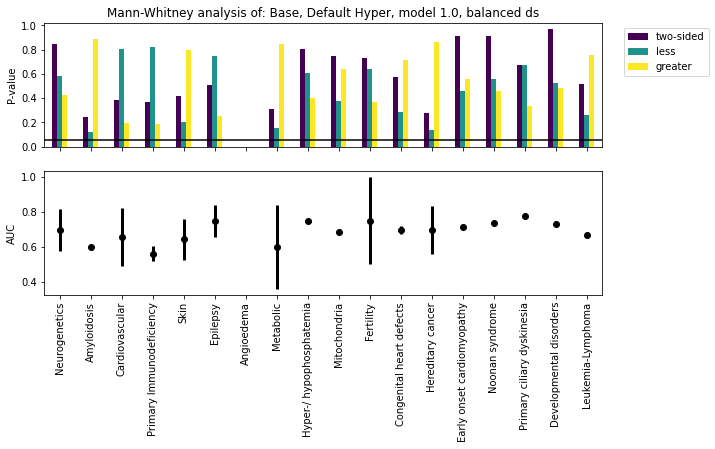

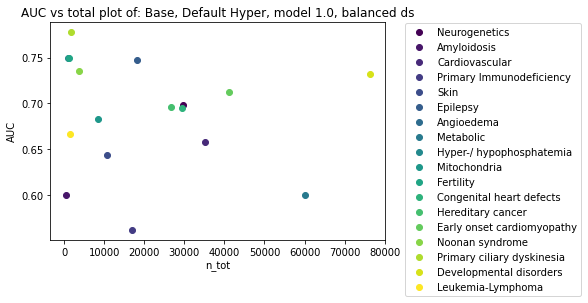

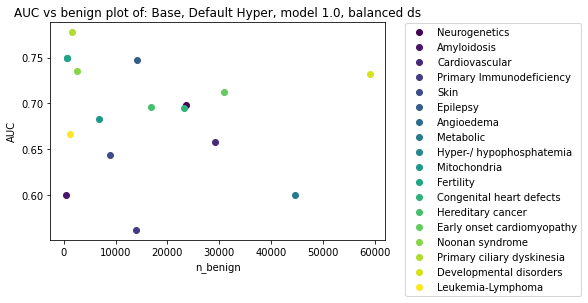

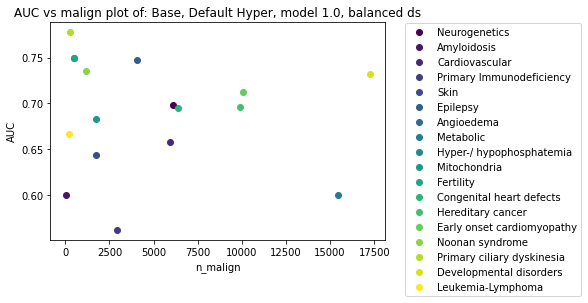

In [6]:
full_auc_analysis(
    curr_setup = 'Base, Default Hyper, model 1.0, balanced ds',
    train_loc = './test_output/train_model1.txt',
    test_loc = './test_output/test_model1.txt',
    auc_analysis_name= 'auc_analysis_model1.csv',
    training_set_loc='./datafiles/train.txt.gz',
    filter_out='./datafiles/train.txt.gz'
)

# Note, Angioedema is not shown in here, 
# since test.txt.gz only contains 3 pathogenic variants for this panel.

#TODO: First calculate AUC of training set, then filter out.

### Base | Default hyper | unbalanced ds
[(Back)](#Full-dataset-AUC-analysis)

There are 334601 samples in the training set.
AUC analysis of the testing dataset reveals AUC: 0.893710301011245
File ./not_saving_directory/auc_analysis_bdhud.csv found. Loading.
Top 10 worst performing genes: 
       gene  auc        f1  recall  fpr  precision  n_benign  n_malign  n_tot  \
320   NLRC4  0.0  0.000000     0.0  1.0   0.000000         1         1      2   
259    SMC3  0.0  0.000000     0.0  1.0   0.000000         4         1      5   
205     ELN  0.0  0.571429     1.0  0.0   0.400000         3         2      5   
200  GABRG2  0.0  0.500000     0.5  0.5   0.500000         1         2      3   
34    FGFR3  0.0  0.857143     1.0  0.0   0.750000         1         3      4   
187   NAA15  0.0  0.400000     1.0  0.0   0.250000         3         1      4   
314    TBX4  0.0  0.000000     0.0  1.0   0.000000         1         1      2   
48      IDS  0.0  0.666667     1.0  0.0   0.500000         1         1      2   
218   NFKB2  0.0  0.500000     1.0  0.0   0.333333         

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:492: UserWarning: Category Angioedema did not contain enough datapoints for Mann-Whitney analysis!
  warnings.warn(f"Category {category} did not contain enough datapoints for Mann-Whitney analysis!")


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.499294  0.753667  0.249647        all               Neurogenetics   
1    0.167967  0.083983  0.921336        all                 Amyloidosis   
2    0.519543  0.743335  0.259771        all              Cardiovascular   
3    0.432420  0.787574  0.216210        all    Primary Immunodeficiency   
4    0.487542  0.243771  0.760279        all                        Skin   
5    0.987029  0.493514  0.510809        all                    Epilepsy   
6         NaN       NaN       NaN        all                  Angioedema   
7    0.355095  0.177548  0.827085        all                   Metabolic   
8    0.804544  0.611344  0.402272        all    Hyper-/ hypophosphatemia   
9    0.376791  0.188396  0.820999        all                Mitochondria   
10   0.403547  0.803981  0.201773        all                   Fertility   
11   0.470376  0.235188  0.771105        all    

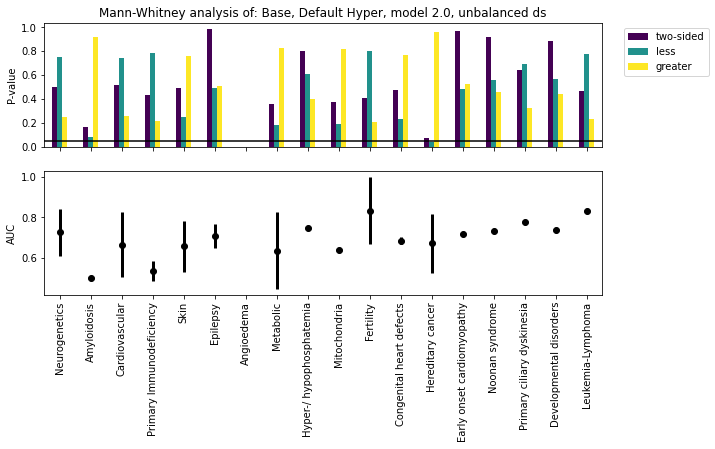

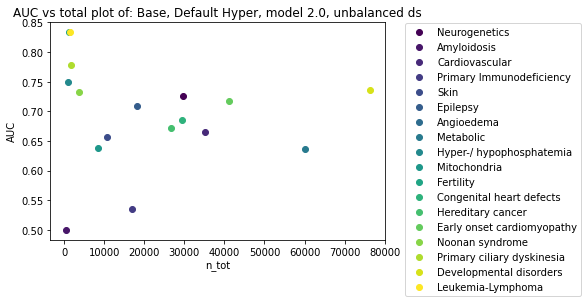

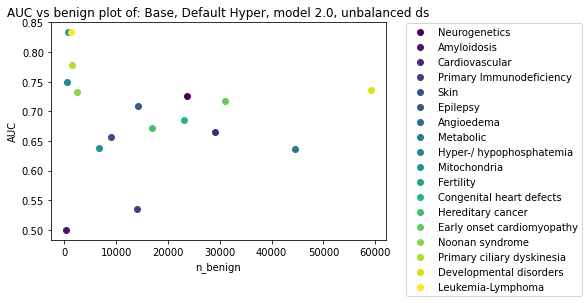

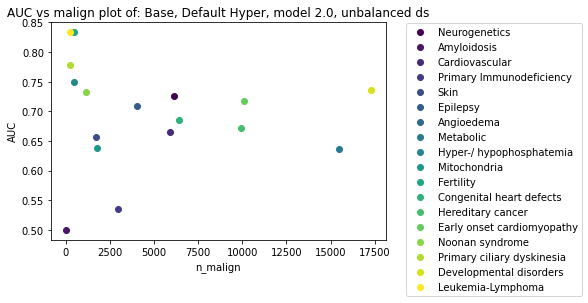

In [7]:
full_auc_analysis(
    curr_setup = 'Base, Default Hyper, model 2.0, unbalanced ds',
    train_loc = './test_output/model_2_0/default_hyper/base/unbalanced/base_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/base/unbalanced/base_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_bdhud.csv',
    training_set_loc = './datafiles/train.txt.gz',
    filter_out='./datafiles/train.txt.gz'
)

# Note, Angioedema is not shown in here, 
# since test.txt.gz only contains 3 pathogenic variants for this panel.

### Base | Default hyper | balanced ds
[(Back)](#Full-dataset-AUC-analysis)

There are 51882 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.9300276293445563
AUC analysis of the testing dataset reveals AUC: 0.9394584540957758
File ./not_saving_directory/auc_analysis_bdhbd.csv found. Loading.
Top 10 worst performing genes: 
          gene  auc        f1  recall  fpr  precision  n_benign  n_malign  \
1694      LIPE  0.0  0.500000     1.0  0.0   0.333333         2         1   
1668    MRPS34  0.0  0.666667     1.0  0.0   0.500000         1         1   
1469     TCF20  0.0  0.923077     1.0  0.0   0.857143         1         6   
1658      SMPX  0.0  0.000000     0.0  1.0   0.000000         2         1   
823       PIGW  0.0  0.666667     1.0  0.0   0.500000         1         1   
354       SORD  0.0  0.500000     1.0  0.0   0.333333         2         1   
920     SLC6A9  0.0  0.500000     1.0  0.0   0.333333         2         1   
964       PURA  0.0  0.181818     1.0  0.0   0.100000         9         1   
1584     MEIS2  0.0  0.333

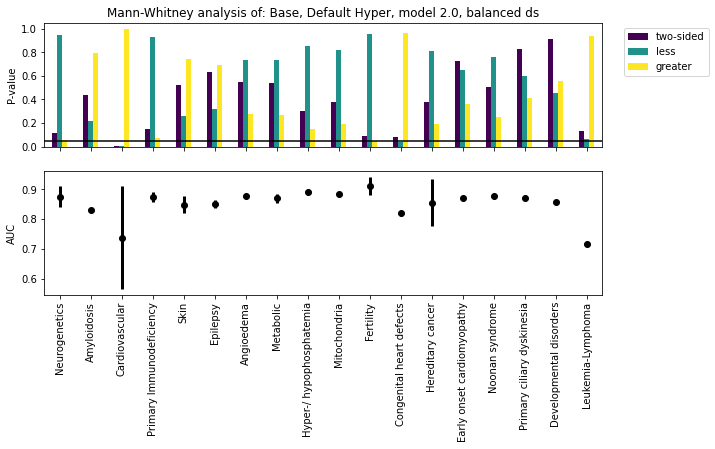

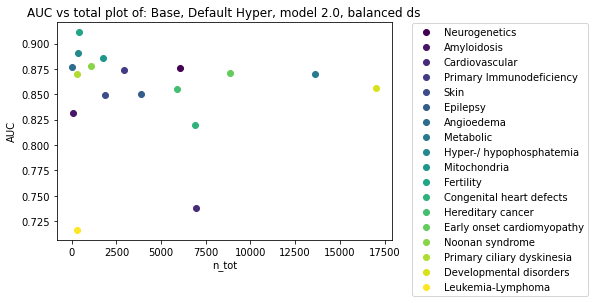

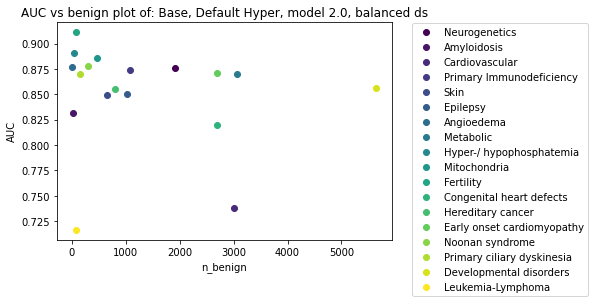

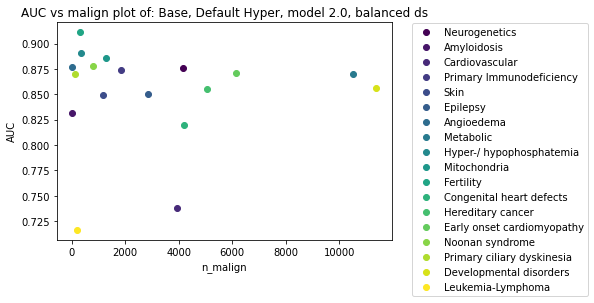

In [8]:
full_auc_analysis(
    curr_setup = 'Base, Default Hyper, model 2.0, balanced ds',
    train_loc = './test_output/model_2_0/default_hyper/base/balanced/base_balanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/base/balanced/base_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_bdhbd.csv',
    training_set_loc = './test_output/model_2_0/default_hyper/base/balanced/train_balanced_dataset.tsv.gz',
    filter_out= './test_output/model_2_0/default_hyper/base/balanced/train_balanced_dataset.tsv.gz'
)

### Base | Optimal hyper | balanced ds
[(Back)](#Full-dataset-AUC-analysis)

Parameter learning_rate is set to 0.09666968094405538
Parameter n_estimators is set to 563
Parameter max_depth is set to 11
There are 51882 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.9303817411916423
AUC analysis of the testing dataset reveals AUC: 0.944057490800174
File ./not_saving_directory/auc_analysis_randomhyper_base_balanced.csv not found, creating.
I am stilling running, done 5%
I am stilling running, done 11%
I am stilling running, done 16%
I am stilling running, done 22%
I am stilling running, done 27%
I am stilling running, done 33%
I am stilling running, done 39%
I am stilling running, done 45%
I am stilling running, done 51%
I am stilling running, done 57%
I am stilling running, done 64%
I am stilling running, done 70%
I am stilling running, done 77%
I am stilling running, done 83%
I am stilling running, done 89%
I am stilling running, done 96%
Top 10 worst performing genes: 
          gene       auc        f1  recall  fpr  precision n

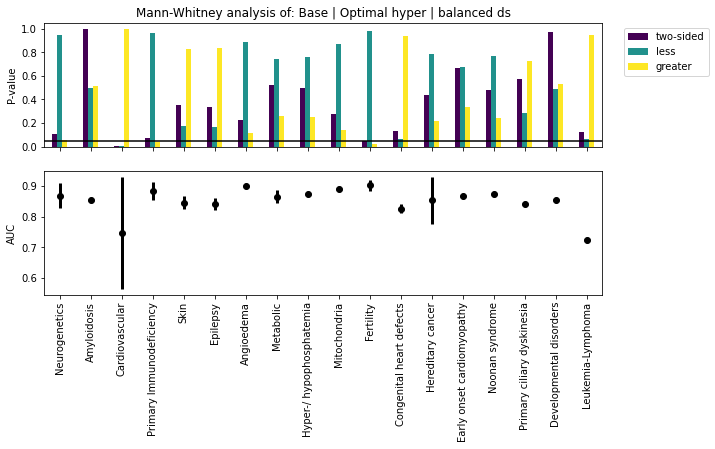

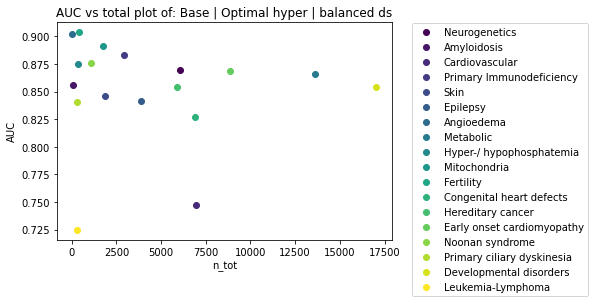

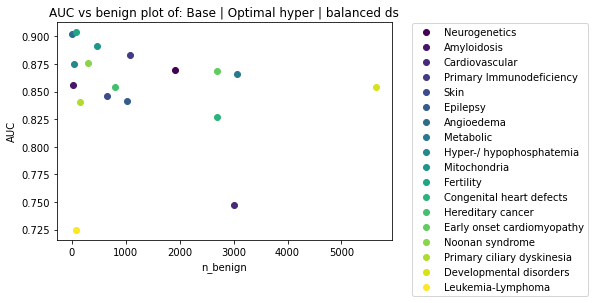

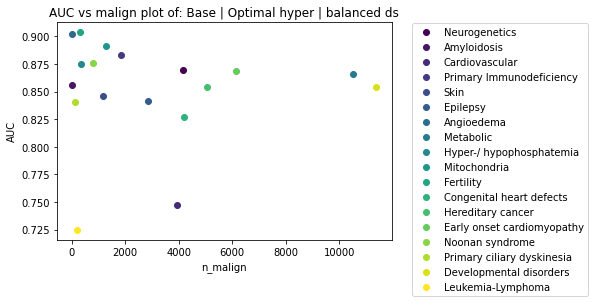

In [11]:
full_auc_analysis(curr_setup = 'Base | Optimal hyper | balanced ds', 
                  training_set_loc='./test_output/model_2_0/random_hyper/base/balanced/train_balanced_dataset.tsv.gz',
                  train_loc='./test_output/model_2_0/random_hyper/base/balanced/base_balanced_train.txt',
                  test_loc='./test_output/model_2_0/random_hyper/base/balanced/base_balanced_test.txt', 
                  auc_analysis_name='auc_analysis_randomhyper_base_balanced.csv', 
                  model='./test_output/model_2_0/random_hyper/base/balanced/xgb_optimal_model.pickle.dat',
                  filter_out='./test_output/model_2_0/random_hyper/base/balanced/train_balanced_dataset.tsv.gz'
                 )

### Base | Optimal hyper | unbalanced ds
[(Back)](#Full-dataset-AUC-analysis)

Parameter learning_rate is set to 0.3313738741131076
Parameter n_estimators is set to 300
Parameter max_depth is set to 13
There are 334601 samples in the training set.
AUC analysis of the testing dataset reveals AUC: 0.9001356915404205
File ./not_saving_directory/auc_analysis_randomhyper_base_unbalanced.csv not found, creating.
Top 10 worst performing genes: 
       gene  auc        f1  recall  fpr  precision n_benign n_malign n_tot  \
160   POMT2  0.0  0.750000     1.0  0.0   0.600000        2        3     5   
41      DSP  0.0  0.956522     1.0  0.0   0.916667        1       11    12   
54      MPZ  0.0  0.941176     1.0  0.0   0.888889        1        8     9   
72   EXOC6B  0.0  0.500000     1.0  0.0   0.333333        2        1     3   
93     SDHD  0.0  0.923077     1.0  0.0   0.857143        1        6     7   
158   NFKB2  0.0  0.500000     1.0  0.0   0.333333        2        1     3   
176     ELN  0.0  0.571429     1.0  0.0   0.400000        3        2     5   
180    TLK2  

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:492: UserWarning: Category Angioedema did not contain enough datapoints for Mann-Whitney analysis!
  warnings.warn(f"Category {category} did not contain enough datapoints for Mann-Whitney analysis!")


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.234522  0.884788  0.117261        all               Neurogenetics   
1    0.658568  0.329284  0.683405        all                 Amyloidosis   
2    0.338862  0.832985  0.169431        all              Cardiovascular   
3    0.402637  0.802309  0.201318        all    Primary Immunodeficiency   
4    0.590243  0.295121  0.709341        all                        Skin   
5    0.172066  0.915656  0.086033        all                    Epilepsy   
6         NaN       NaN       NaN        all                  Angioedema   
7    0.318993  0.159497  0.844824        all                   Metabolic   
8    1.000000  0.500000  0.514100        all    Hyper-/ hypophosphatemia   
9    0.179159  0.089580  0.916006        all                Mitochondria   
10   0.397790  0.806810  0.198895        all                   Fertility   
11   0.397790  0.198895  0.806810        all    

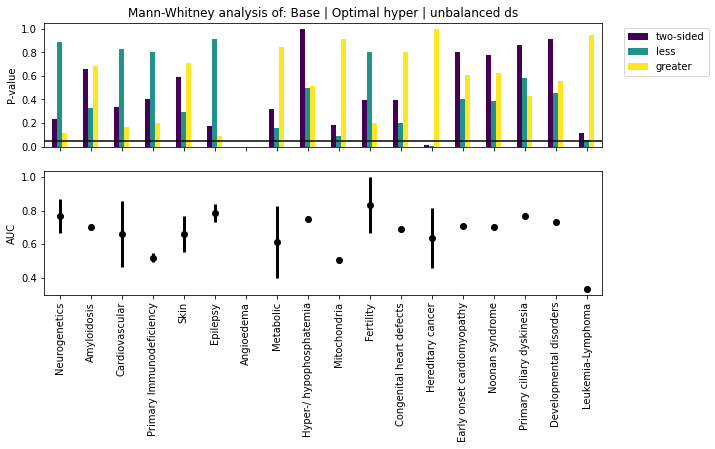

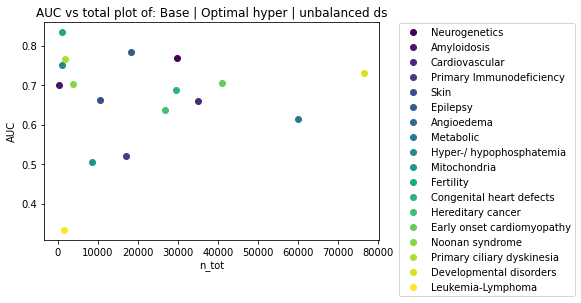

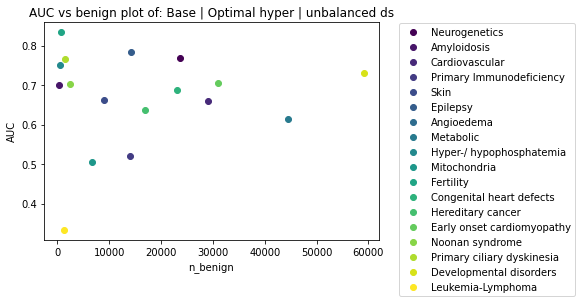

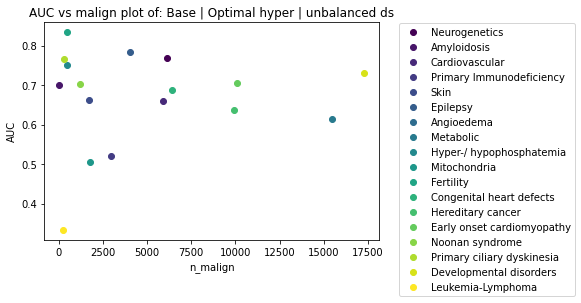

In [12]:
full_auc_analysis(curr_setup = 'Base | Optimal hyper | unbalanced ds', 
                  training_set_loc='./datafiles/train.txt.gz',
                  train_loc='./test_output/model_2_0/random_hyper/base/unbalanced/base_unbalanced_train.txt',
                  test_loc='./test_output/model_2_0/random_hyper/base/unbalanced/base_unbalanced_test.txt', 
                  auc_analysis_name='auc_analysis_randomhyper_base_unbalanced.csv', 
                  model='./test_output/model_2_0/random_hyper/base/unbalanced/xgb_optimal_model.pickle.dat',
                  filter_out='./datafiles/train.txt.gz'
                 )

# Note, Angioedema is not shown in here, 
# since test.txt.gz only contains 3 pathogenic variants for this panel.

# Preparing training data for Cardiovascular
[Index](#Index)

In [8]:
hevz = []
for key, value in genepanels['Hart- en vaatziekten'].items():
    for gene in value:
        if gene not in hevz:
            hevz.append(gene)
hevz

['ABCC8',
 'ACTA2',
 'ACVRL1',
 'AQP1',
 'ATP13A3',
 'BMPR1B',
 'BMPR2',
 'CAV1',
 'EIF2AK4',
 'ENG',
 'GDF2',
 'GGCX',
 'KCNA5',
 'KCNK3',
 'KDR',
 'KLF2',
 'KLK1',
 'SMAD4',
 'SMAD9',
 'SOX17',
 'TBX4',
 'ABCC9',
 'AKAP9',
 'ANK2',
 'ASPH',
 'CACNA1C',
 'CACNA1D',
 'CACNA2D1',
 'CACNB2',
 'CALM1',
 'CALM2',
 'CALM3',
 'CASQ2',
 'CAV3',
 'GJA5',
 'GNB2',
 'GPD1L',
 'HCN4',
 'JPH2',
 'KCND3',
 'KCNE1',
 'KCNE2',
 'KCNE3',
 'KCNE1L',
 'KCNH2',
 'KCNJ2',
 'KCNJ5',
 'KCNJ8',
 'KCNQ1',
 'LAMP2',
 'LMNA',
 'MYL4',
 'NKX2-5',
 'NPPA',
 'PKP2',
 'PLN',
 'PPA2',
 'PRKAG2',
 'RANGRF',
 'RYR2',
 'SCN10A',
 'SCN1B',
 'SCN2B',
 'SCN3B',
 'SCN4B',
 'SCN5A',
 'SLMAP',
 'SNTA1',
 'TECRL',
 'TNNI3K',
 'TNNT2',
 'TRDN',
 'TRPM4',
 'CYP27A1',
 'SAR1B',
 'APOE',
 'ABCA1',
 'ABCG5',
 'ABCG8',
 'ANGPTL3',
 'APOA1',
 'APOA5',
 'APOB',
 'APOC2',
 'APOC3',
 'CETP',
 'CYP7A1',
 'GPD1',
 'GPIHBP1',
 'LCAT',
 'LDLR',
 'LDLRAP1',
 'LIPA',
 'LIPC',
 'LIPG',
 'LMF1',
 'LPL',
 'MTTP',
 'MYLIP',
 'PCSK9',
 'SCARB1',


In [9]:
training_dataset = pd.read_csv('./datafiles/train.txt.gz', sep='\t', low_memory=False)
training_dataset

#Chrom  Allergy/Immunology/Infectious Alt          AnnoType  \
0          14                          False   G  CodingTranscript   
1          20                          False   T  CodingTranscript   
2          20                          False   C  CodingTranscript   
3          20                          False   A  CodingTranscript   
4          20                          False   A        Intergenic   
...       ...                            ...  ..               ...   
334596     17                          False   A  CodingTranscript   
334597     17                          False   T  CodingTranscript   
334598     10                          False   T  CodingTranscript   
334599      2                          False   T  CodingTranscript   
334600      5                          False   T  CodingTranscript   

        Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
0                            False        False   CCDS9787.1   806.0   
1                             True        False  CCDS13112.1  1899.0   
2                             True        False  CCDS13112.1  2118.0   
3                             True        False  CCDS13112.1  1586.0   
4                             True        False          NaN     NaN   
...                            ...          ...          ...     ...   
334596                       False        False  CCDS32642.1  1563.0   
334597                       False        False  CCDS32642.1  2029.0   
334598                       False        False   CCDS7431.1  1216.0   
334599                       False        False   CCDS2382.1  2998.0   
334600                       False        False   CCDS3952.1  1221.0   

        Cardiovascular              ConsDetail  ...  revel sift   source  \
0                False              frameshift  ...    NaN  NaN     vkgl   
1                 True  frameshift,stop_gained  ...    NaN  NaN     vkgl   
2                 True              frameshift  ...    NaN  NaN     vkgl   
3                 True              frameshift  ...    NaN  NaN     vkgl   
4                 True              downstream  ...    NaN  NaN     vkgl   
...                ...                     ...  ...    ...  ...      ...   
334596           False             stop_gained  ...    NaN  NaN  unknown   
334597           False             stop_gained  ...    NaN  NaN  unknown   
334598           False             stop_gained  ...    NaN  NaN  unknown   
334599           False             stop_gained  ...    NaN  NaN  unknown   
334600           False             stop_gained  ...    NaN  NaN  unknown   

        tOverlapMotifs  targetScan  to_be_deleted  verPhCons verPhyloP inTest  \
0                  NaN         NaN          False      1.000     5.843  False   
1                  NaN         NaN          False      1.000     4.670  False   
2                  NaN         NaN          False      1.000     5.043  False   
3                  NaN         NaN          False      1.000     6.221  False   
4                  NaN         NaN          False      1.000     6.368  False   
...                ...         ...            ...        ...       ...    ...   
334596             NaN         NaN          False      1.000     6.031  False   
334597             NaN         NaN          False      1.000     4.100  False   
334598             NaN         NaN          False      1.000     5.852  False   
334599             NaN         NaN          False      0.031     2.213  False   
334600             NaN         NaN          False      1.000     0.528  False   

        sample_weight  
0                 1.0  
1                 1.0  
2                 1.0  
3                 1.0  
4                 1.0  
...               ...  
334596            0.8  
334597            0.8  
334598            0.8  
334599            0.8  
334600            0.8  

[334601 rows x 152 columns]

In [10]:
for c in training_dataset.columns:
    print(c)

#Chrom
Allergy/Immunology/Infectious
Alt
AnnoType
Audiologic/Otolaryngologic
Biochemical
CCDS
CDSpos
Cardiovascular
ConsDetail
ConsScore
Consequence
CpG
Craniofacial
Dental
Dermatologic
Dist2Mutation
Domain
Dst2SplType
Dst2Splice
EncExp
EncH3K27Ac
EncH3K4Me1
EncH3K4Me3
EncNucleo
EncOCC
EncOCCombPVal
EncOCDNasePVal
EncOCDNaseSig
EncOCFairePVal
EncOCFaireSig
EncOCctcfPVal
EncOCctcfSig
EncOCmycPVal
EncOCmycSig
EncOCpolIIPVal
EncOCpolIISig
Endocrine
Exon
FeatureID
Freq10000bp
Freq1000bp
Freq100bp
GC
Gastrointestinal
GeneID
GeneName
General
Genitourinary
GerpN
GerpRS
GerpRSpval
GerpS
Grantham
Hematologic
Intron
Length
Musculoskeletal
Neurologic
Obstetric
Oncologic
Ophthalmologic
PHRED
PolyPhenCat
PolyPhenVal
Pos
Pulmonary
Rare10000bp
Rare1000bp
Rare100bp
RawScore
Ref
Renal
SIFTcat
SIFTval
Segway
Sngl10000bp
Sngl1000bp
Sngl100bp
Stars
TFBS
TFBSPeaks
TFBSPeaksMax
Type
allvalid
bStatistic
binarized_label
cDNApos
cHmmBivFlnk
cHmmEnh
cHmmEnhBiv
cHmmEnhG
cHmmHet
cHmmQuies
cHmmReprPC
cHmmReprPCWk


In [11]:
training_dataset[training_dataset['GeneName'].isin(hevz)]

#Chrom  Allergy/Immunology/Infectious        Alt          AnnoType  \
18         15                          False         AA  CodingTranscript   
21          7                          False         GG  CodingTranscript   
22         11                          False          G  CodingTranscript   
23         11                          False          A  CodingTranscript   
24         11                          False        AGC  CodingTranscript   
...       ...                            ...        ...               ...   
334579     12                          False          A  CodingTranscript   
334580     12                          False          T  CodingTranscript   
334581     12                          False          C  CodingTranscript   
334582     12                          False  CATTTTCAT  CodingTranscript   
334583     12                          False          T  CodingTranscript   

        Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
18                           False        False  CCDS42016.1  1737.0   
21                           False        False   CCDS5928.1   431.0   
22                           False        False  CCDS53621.1   884.0   
23                           False        False  CCDS53621.1  2532.0   
24                           False        False  CCDS53621.1  3685.0   
...                            ...          ...          ...     ...   
334579                       False        False   CCDS8693.1  2080.0   
334580                       False        False   CCDS8693.1  1529.0   
334581                       False        False   CCDS8693.1  1119.0   
334582                       False        False   CCDS8693.1  1034.0   
334583                       False        False   CCDS8693.1   671.0   

        Cardiovascular              ConsDetail  ...  revel sift   source  \
18                True              frameshift  ...    NaN  NaN     vkgl   
21                True              frameshift  ...    NaN  NaN     vkgl   
22                True              frameshift  ...    NaN  NaN     vkgl   
23                True              frameshift  ...    NaN  NaN     vkgl   
24                True              frameshift  ...    NaN  NaN     vkgl   
...                ...                     ...  ...    ...  ...      ...   
334579            True             stop_gained  ...    NaN  NaN  unknown   
334580            True             stop_gained  ...    NaN  NaN  unknown   
334581            True             stop_gained  ...    NaN  NaN  unknown   
334582            True  frameshift,stop_gained  ...    NaN  NaN  unknown   
334583            True             stop_gained  ...    NaN  NaN  unknown   

        tOverlapMotifs  targetScan  to_be_deleted  verPhCons verPhyloP inTest  \
18                 NaN         NaN           True      1.000     4.472  False   
21                 NaN         NaN           True      0.995     3.815  False   
22                 NaN         NaN          False      1.000     4.533  False   
23                 NaN         NaN          False      1.000     5.262  False   
24                 NaN         NaN           True      1.000     3.135  False   
...                ...         ...            ...        ...       ...    ...   
334579             NaN         NaN          False      1.000     3.492  False   
334580             NaN         NaN          False      1.000     5.757  False   
334581             NaN         NaN          False      1.000     4.145  False   
334582             NaN         NaN          False      1.000     0.938  False   
334583             NaN         NaN          False      1.000     5.889  False   

        sample_weight  
18                1.0  
21                1.0  
22                1.0  
23                1.0  
24                1.0  
...               ...  
334579            0.8  
334580            0.8  
334581            0.8  
334582            0.8  
334583            0.8  

[35058 rows x 152 columns]

In [12]:
filename = './datafiles/cardiovascular.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(hevz)].to_csv('./datafiles/cardiovascular.txt.gz', compression='gzip', index=False, sep='\t')

# Preparing data for Dyslipid.
[Index](#Index)

In [13]:
dyslipid_related = []
for key, value in genepanels['Hart- en vaatziekten'].items():
    if key.lower().startswith('dyslipid'):
        for gene in value:
            if gene not in dyslipid_related:
                dyslipid_related.append(gene)
dyslipid_related

['CYP27A1',
 'SAR1B',
 'APOE',
 'ABCA1',
 'ABCG5',
 'ABCG8',
 'ANGPTL3',
 'APOA1',
 'APOA5',
 'APOB',
 'APOC2',
 'APOC3',
 'CETP',
 'CYP7A1',
 'GPD1',
 'GPIHBP1',
 'LCAT',
 'LDLR',
 'LDLRAP1',
 'LIPA',
 'LIPC',
 'LIPG',
 'LMF1',
 'LPL',
 'MTTP',
 'MYLIP',
 'PCSK9',
 'SCARB1',
 'SLCO1B1',
 'STAP1']

In [14]:
training_dataset[training_dataset['GeneName'].isin(dyslipid_related)]

#Chrom  Allergy/Immunology/Infectious                     Alt  \
142        16                          False                       T   
148        19                          False  CCGGCGAGGTGCAGGCCATGCT   
149         2                          False                       C   
150         2                          False                       G   
151         2                          False                       C   
...       ...                            ...                     ...   
334284     12                          False                       T   
334285     12                          False                       A   
334286     12                          False                       T   
334287     12                          False                       G   
334288     12                          False                       G   

                AnnoType  Audiologic/Otolaryngologic  Biochemical  \
142     CodingTranscript                       False        False   
148     CodingTranscript                       False        False   
149     CodingTranscript                       False        False   
150     CodingTranscript                       False        False   
151     CodingTranscript                       False        False   
...                  ...                         ...          ...   
334284  CodingTranscript                       False        False   
334285  CodingTranscript                       False        False   
334286  CodingTranscript                       False        False   
334287  CodingTranscript                       False        False   
334288  CodingTranscript                       False        False   

               CCDS   CDSpos  Cardiovascular        ConsDetail  ...  revel  \
142     CCDS10772.1    848.0            True        frameshift  ...    NaN   
148     CCDS12647.1    409.0            True  protein_altering  ...    NaN   
149      CCDS1703.1  13028.0            True        frameshift  ...    NaN   
150      CCDS1703.1     28.0            True        frameshift  ...    NaN   
151      CCDS1703.1   2534.0            True        frameshift  ...    NaN   
...             ...      ...             ...               ...  ...    ...   
334284   CCDS8685.1   1093.0           False       stop_gained  ...    NaN   
334285   CCDS8685.1   1475.0           False       stop_gained  ...    NaN   
334286   CCDS8685.1   1537.0           False       stop_gained  ...    NaN   
334287   CCDS8685.1   1553.0           False       stop_gained  ...    NaN   
334288   CCDS8685.1   1634.0           False       stop_gained  ...    NaN   

       sift   source  tOverlapMotifs  targetScan  to_be_deleted  verPhCons  \
142     NaN     vkgl             NaN         NaN          False      0.928   
148     NaN     vkgl             NaN         NaN           True      0.863   
149     NaN     vkgl             NaN         NaN          False      0.000   
150     NaN     vkgl             NaN         NaN          False      0.021   
151     NaN     vkgl             NaN         NaN          False      0.653   
...     ...      ...             ...         ...            ...        ...   
334284  NaN  unknown             NaN         NaN          False      0.999   
334285  NaN  unknown             NaN         NaN          False      0.580   
334286  NaN  unknown             NaN         NaN          False      0.003   
334287  NaN  unknown             NaN         NaN          False      0.510   
334288  NaN  unknown             NaN         NaN          False      0.000   

       verPhyloP inTest  sample_weight  
142        2.614  False            1.0  
148        0.839  False            1.0  
149        0.058  False            1.0  
150       -0.103  False            1.0  
151        0.251  False            1.0  
...          ...    ...            ...  
334284     3.072  False            0.8  
334285     0.563  False            0.8  
334286     0.643  False            0.8  
334287     2.765  False      

In [15]:
filename = './datafiles/dyslipid.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(dyslipid_related)].to_csv(filename, compression='gzip', index=False, sep='\t')

# Preparing data for Neurogenetics.
[Index](#Index)

In [16]:
neuro = []
for key, value in genepanels['Neurogenetica'].items():
    for gene in value:
        if gene not in neuro:
            neuro.append(gene)
neuro

['APP',
 'APOE',
 'CHMP2B',
 'CSF1R',
 'FUS',
 'GRN',
 'MAPT',
 'NPC1',
 'PRNP',
 'PSEN1',
 'PSEN2',
 'SIGMAR1',
 'SORL1',
 'TARDBP',
 'TREM2',
 'UBE3A',
 'UBQLN2',
 'VCP',
 'ADH1C',
 'ATP13A2',
 'ATP1A3',
 'DNAJC13',
 'DNAJC6',
 'EIF4G1',
 'FBXO7',
 'GBA',
 'GIGYF2',
 'HTRA2',
 'LRRK2',
 'PARK2',
 'PARK7',
 'PINK1',
 'PLA2G6',
 'PRKRA',
 'SLC6A3',
 'SNCA',
 'SYNJ1',
 'TAF1',
 'UCHL1',
 'VPS35',
 'C19orf12',
 'CP',
 'FA2H',
 'FTL',
 'PANK2',
 'SLC30A10',
 'WDR45',
 'AP1S2',
 'FGF17',
 'FOXC1',
 'LAMC1',
 'NID1',
 'ZIC1',
 'ZIC4',
 'ADCK3',
 'ADCY5',
 'AMT',
 'ANO3',
 'ARHGEF9',
 'ASAH1',
 'ATM',
 'ATP7A',
 'ATP7B',
 'BRAT1',
 'CACNA1A',
 'CACNA1B',
 'CACNB4',
 'CAMTA1',
 'CARS2',
 'CASR',
 'CDKL5',
 'CERS1',
 'CHD2',
 'CLCN2',
 'CLN3',
 'CLN5',
 'CLN6',
 'CLN8',
 'CNTN2',
 'CSTB',
 'CYP27A1',
 'DNAJC5',
 'EFHC1',
 'EIF2B5',
 'EPM2A',
 'FOLR1',
 'FOXG1',
 'GABRA1',
 'GABRD',
 'GABRG2',
 'GALC',
 'GCSH',
 'GFAP',
 'GLDC',
 'GLRA1',
 'GLRB',
 'GNAO1',
 'GOSR2',
 'HEXA',
 'HEXB',
 'KCNC1',

In [17]:
training_dataset[training_dataset['GeneName'].isin(neuro)]

#Chrom  Allergy/Immunology/Infectious Alt          AnnoType  \
49          6                          False   T  CodingTranscript   
114         3                          False  AT  CodingTranscript   
128         2                          False   G  CodingTranscript   
129         2                          False   C  CodingTranscript   
143        15                          False  TT  CodingTranscript   
...       ...                            ...  ..               ...   
334455     11                          False   A  CodingTranscript   
334511     10                          False   A  CodingTranscript   
334512     10                          False   A  CodingTranscript   
334573      X                          False   A  CodingTranscript   
334574      X                          False   T  CodingTranscript   

        Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
49                           False        False   CCDS5004.1  1837.0   
114                          False        False   CCDS2925.1   666.0   
128                           True         True   CCDS2419.1   398.0   
129                           True         True   CCDS2419.1   940.0   
143                          False        False  CCDS42029.1  1207.0   
...                            ...          ...          ...     ...   
334455                       False        False  CCDS31452.1   163.0   
334511                       False        False  CCDS31314.1  1381.0   
334512                       False        False  CCDS31314.1  1165.0   
334573                       False         True  CCDS14728.1   230.0   
334574                       False         True  CCDS14728.1  1699.0   

        Cardiovascular          ConsDetail  ...  revel sift   source  \
49               False          frameshift  ...    NaN  NaN     vkgl   
114              False          frameshift  ...    NaN  NaN     vkgl   
128              False          frameshift  ...    NaN  NaN     vkgl   
129              False          frameshift  ...    NaN  NaN     vkgl   
143              False          frameshift  ...    NaN  NaN     vkgl   
...                ...                 ...  ...    ...  ...      ...   
334455           False         stop_gained  ...    NaN  NaN  unknown   
334511           False         stop_gained  ...  0.173  NaN  unknown   
334512           False  splice,stop_gained  ...    NaN  NaN  unknown   
334573           False         stop_gained  ...    NaN  NaN  unknown   
334574           False         stop_gained  ...    NaN  NaN  unknown   

        tOverlapMotifs  targetScan  to_be_deleted  verPhCons verPhyloP inTest  \
49                 NaN         NaN          False      1.000     5.778  False   
114                NaN         NaN           True      1.000     5.747  False   
128                NaN         NaN          False      1.000     4.997  False   
129                NaN         NaN          False      1.000     3.298  False   
143                NaN         NaN           True      1.000     5.600  False   
...                ...         ...            ...        ...       ...    ...   
334455             NaN         NaN          False      1.000     5.586  False   
334511             NaN         NaN          False      1.000     3.144  False   
334512             NaN         NaN          False      1.000     6.319  False   
334573             NaN         NaN          False      1.000     1.741  False   
334574             NaN         NaN          False      0.115     0.142  False   

        sample_weight  
49                1.0  
114               1.0  
128               1.0  
129               1.0  
143               1.0  
...               ...  
334455            0.8  
334511            0.8  
334512            0.8  
334573            0.8  
334574            0.8  

[29769 rows x 152 columns]

In [18]:
filename = './datafiles/neurogenetics.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(neuro)].to_csv(filename, compression='gzip', index=False, sep='\t')

# Preparing data for Hereditary cancer
[Index](#Index)

In [19]:
hc = []
for key, value in genepanels['Erfelijke Kanker'].items():
    for gene in value:
        if gene not in hc:
            hc.append(gene)
hc

['ATM',
 'BRCA1',
 'BRCA2',
 'CHEK2',
 'PALB2',
 'TP53',
 'EPCAM',
 'MLH1',
 'MSH2',
 'MSH6',
 'MUTYH',
 'PMS2',
 'POLD1',
 'POLE',
 'APC',
 'AXIN2',
 'BMPR1A',
 'ENG',
 'MSH3',
 'NTHL1',
 'PTEN',
 'RNF43',
 'SMAD4',
 'STK11',
 'BRIP1',
 'RAD51C',
 'RAD51D',
 'FH',
 'MAX',
 'MDH2',
 'NF1',
 'RET',
 'SDHA',
 'SDHAF2',
 'SDHB',
 'SDHC',
 'SDHD',
 'TMEM127',
 'VHL',
 'AIP',
 'CDKN1A',
 'CDKN1B',
 'CDKN2B',
 'CDKN2C',
 'MEN1',
 'PRKAR1A',
 'ACD',
 'ACTRT1',
 'BAP1',
 'CDK4',
 'CDKN2A',
 'ERCC2',
 'MITF',
 'POLH',
 'POT1',
 'PTCH1',
 'PTCH2',
 'SUFU',
 'TERF2IP',
 'TERT',
 'DICER1',
 'LZTR1',
 'NF2',
 'SMARCA4',
 'SMARCB1',
 'SMARCE1',
 'TSC1',
 'TSC2',
 'ALK',
 'PHOX2B',
 'WT1',
 'CEBPA',
 'DDX41',
 'GATA2',
 'PAX5',
 'RUNX1',
 'CDH1',
 'CTNNA1',
 'FLCN',
 'MET',
 'PALLD',
 'HOXB13',
 'RB1',
 'EGFR',
 'CDC73',
 'KIT',
 'PDGFRA']

In [20]:
training_dataset[training_dataset['GeneName'].isin(hc)]

#Chrom  Allergy/Immunology/Infectious       Alt          AnnoType  \
55          2                          False         A  CodingTranscript   
56          2                          False        TA  CodingTranscript   
57          2                          False        CC  CodingTranscript   
58          2                          False         C  CodingTranscript   
59          2                          False        AT  CodingTranscript   
...       ...                            ...       ...               ...   
334504      5                          False         T  CodingTranscript   
334505      5                          False  GACAAAGA  CodingTranscript   
334533     17                          False         A  CodingTranscript   
334534     17                          False         A  CodingTranscript   
334535     17                          False         C  CodingTranscript   

        Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
55                           False        False   CCDS1836.1   741.0   
56                           False        False   CCDS1836.1  1944.0   
57                           False        False   CCDS1836.1  3259.0   
58                           False        False   CCDS1836.1   102.0   
59                           False        False   CCDS1836.1   395.0   
...                            ...          ...          ...     ...   
334504                       False        False   CCDS4107.1  3925.0   
334505                       False        False   CCDS4107.1  4160.0   
334533                       False        False  CCDS45646.1   271.0   
334534                       False        False  CCDS45646.1   184.0   
334535                       False        False  CCDS45646.1   161.0   

        Cardiovascular              ConsDetail  ...  revel sift   source  \
55               False              frameshift  ...    NaN  NaN     vkgl   
56               False              frameshift  ...    NaN  NaN     vkgl   
57               False              frameshift  ...    NaN  NaN     vkgl   
58               False              frameshift  ...    NaN  NaN     vkgl   
59               False              frameshift  ...    NaN  NaN     vkgl   
...                ...                     ...  ...    ...  ...      ...   
334504           False             stop_gained  ...    NaN  NaN  unknown   
334505           False  frameshift,stop_gained  ...    NaN  NaN  unknown   
334533           False             stop_gained  ...    NaN  NaN  unknown   
334534           False             stop_gained  ...    NaN  NaN  unknown   
334535           False             stop_gained  ...  0.017  NaN  unknown   

        tOverlapMotifs  targetScan  to_be_deleted  verPhCons verPhyloP inTest  \
55                 NaN         NaN          False      0.839    -0.283  False   
56                 NaN         NaN           True      0.001     0.466  False   
57                 NaN         NaN           True      1.000     3.249  False   
58                 NaN         NaN          False      0.000    -0.743  False   
59                 NaN         NaN           True      1.000     5.138  False   
...                ...         ...            ...        ...       ...    ...   
334504             NaN         NaN          False      1.000     3.528  False   
334505             NaN         NaN          False      1.000     5.909  False   
334533             NaN         NaN          False      0.003     0.639  False   
334534             NaN         NaN          False      0.003     0.266  False   
334535             NaN         NaN          False      0.004     0.318  False   

        sample_weight  
55                1.0  
56                1.0  
57                1.0  
58                1.0  
59                1.0  
...               ...  
334504            0.8  
334505            0.8  
334533            0.8  
334534            0.8  
334535            0.8  

[26776 rows x 152 columns]

In [21]:
filename = './datafiles/hereditarycancer.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(hc)].to_csv(filename, compression='gzip', index=False, sep='\t')

# AUC analysis of dyslipid model
[Index](#Index)

In [22]:
test_dyslipid = read_capice_output('./test_output/test_results_dyslipid_correct_threshold.txt')
test_dyslipid

GeneName     Consequence   PHRED  probabilities  prediction  \
0             BRCA1     STOP_GAINED  34.000   9.999996e-01  Pathogenic   
1             BRCA2     FRAME_SHIFT  26.900   9.999989e-01  Pathogenic   
2             BRCA1     FRAME_SHIFT  22.000   9.999983e-01  Pathogenic   
3             BRCA1     FRAME_SHIFT  22.000   9.999982e-01  Pathogenic   
4             BRCA2     FRAME_SHIFT  22.600   9.999980e-01  Pathogenic   
...             ...             ...     ...            ...         ...   
10837  BLOC1S1-RDH5      DOWNSTREAM   8.009   1.597412e-07     Neutral   
10838  LOC100289580        UPSTREAM   0.168   7.783050e-08     Neutral   
10839         MYHAS      DOWNSTREAM   0.035   6.001463e-08     Neutral   
10840  LOC100289580        UPSTREAM   1.856   4.832236e-08     Neutral   
10841      MIR548AZ  NON_SYNONYMOUS   1.347   4.640942e-08     Neutral   

      combined_prediction chr       pos    ref   alt  
0              Pathogenic  17  41243705  CTGAG  GCCT  
1              Pathogenic  13  32912883    CTG    TT  
2              Pathogenic  17  41245330  CTTTA   TTT  
3              Pathogenic  17  41245404    GTA    CT  
4              Pathogenic  13  32915061     TA     T  
...                   ...  ..       ...    ...   ...  
10837             Neutral  12  56115746      G     C  
10838             Neutral  16  88801032      G     T  
10839             Neutral  17  10442488      G     A  
10840             Neutral  16  88798720      G     A  
10841             Neutral  14  64519932      A     G  

[10842 rows x 10 columns]

# AUC analysis on Specific models

_Note: this balanced / unbalanced dataset is what the model was trained on_

### Default hyperparameters

[Cardiovascular, default hyperparameters, balanced dataset.](#Cardiovascular-|-Default-hyper-|-balanced)

[Cardiovascular, default hyperparameters, unbalanced dataset.](#Cardiovascular-|-Default-hyper-|-unbalanced)

[Dyslipid, default hyperparameters, balanced dataset.](#Dyslipid-|-Default-hyper-|-balanced)

[Dyslipid, default hyperparameters, unbalanced dataset.](#Dyslipid-|-Default-hyper-|-unbalanced)

[Hereditary cancer, default hyperparameters, balanced dataset.](#Hereditary-cancer-|-Default-hyper-|-balanced)

[Hereditary cancer, default hyperparameters, unbalanced dataset.](#Hereditary-cancer-|-Default-hyper-|-unbalanced)

[Neurogenetics, default hyperparameters, balanced dataset.](#Neurogenetics-|-Default-hyper-|-balanced)

[Neurogenetics, default hyperparameters, unbalanced dataset.](#Neurogenetics-|-Default-hyper-|-unbalanced)

### Optimal Hyperparameters

[Cardiovascular, optimal hyperparameters, balanced dataset.](#Cardiovascular-|-Optimal-hyper-|-balanced)

[Cardiovascular, optimal hyperparameters, unbalanced dataset.](#Cardiovascular-|-Optimal-hyper-|-unbalanced)

[Dyslipid, optimal hyperparameters, balanced dataset.](#Dyslipid-|-Optimal-hyper-|-balanced)

[Dyslipid, optimal hyperparameters, unbalanced dataset.](#Dyslipid-|-Optimal-hyper-|-unbalanced)

[Hereditary cancer, optimal hyperparameters, balanced dataset.](#Hereditary-cancer-|-Optimal-hyper-|-balanced)

[Hereditary cancer, optimal hyperparameters, unbalanced dataset.](#Hereditary-cancer-|-Optimal-hyper-|-unbalanced)

[Neurogenetics, optimal hyperparameters, balanced dataset.](#Neurogenetics-|-Optimal-hyper-|-balanced)

[Neurogenetics, optimal hyperparameters, unbalanced dataset.](#Neurogenetics-|-Optimal-hyper-|-unbalanced)

<br></br>
[Index](#Index)

### Cardiovascular | Default hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

There are 6642 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.7588318255473785
AUC analysis of the testing dataset reveals AUC: 0.6713240620308657
File ./not_saving_directory/auc_analysis_cardio_balanced.csv found. Loading.
Top 10 worst performing genes: 
          gene  auc        f1    recall       fpr  precision  n_benign  \
2278     TEX15  0.0  0.000000  0.000000  1.000000   0.000000         3   
2242  KIAA0753  0.0  0.500000  0.666667  0.333333   0.400000         3   
1971      PLD1  0.0  0.666667  1.000000  0.000000   0.500000         1   
1969  HIST1H1E  0.0  0.285714  1.000000  0.000000   0.166667         5   
2319       PTH  0.0  0.000000  0.000000  1.000000   0.000000         3   
1165      PIGW  0.0  0.857143  1.000000  0.000000   0.750000         1   
1400     ERMAP  0.0  0.000000  0.000000  1.000000   0.000000        21   
2269     CDK10  0.0  0.800000  1.000000  0.000000   0.666667         1   
2270      FSHB  0.0  0.400000  1.000000  0.0

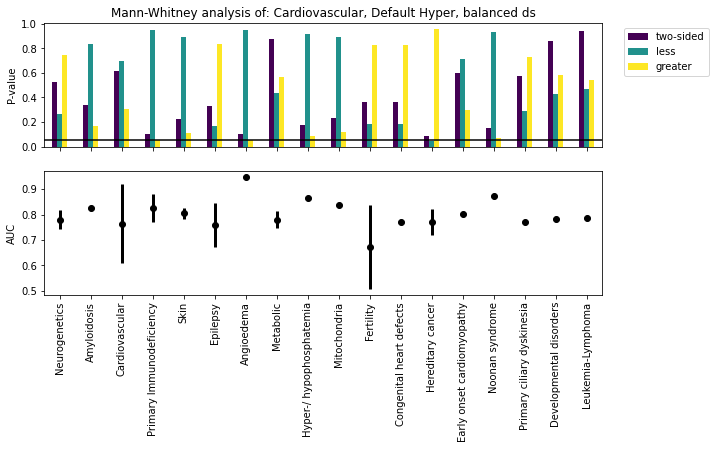

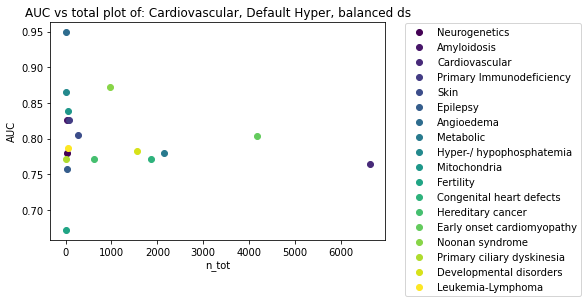

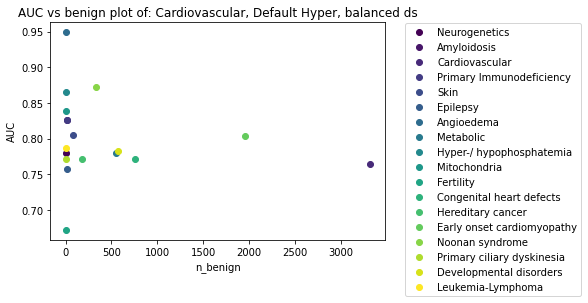

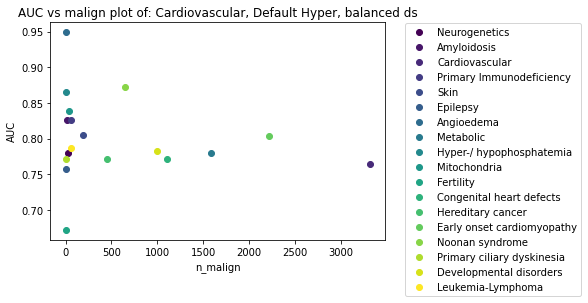

In [13]:
full_auc_analysis(
    curr_setup = 'Cardiovascular, Default Hyper, balanced ds',
    train_loc = './test_output/model_2_0/default_hyper/cardiovascular/balanced/cardiovascular_balanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/cardiovascular/balanced/cardiovascular_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_cardio_balanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz',
    filter_out='./test_output/model_2_0/default_hyper/cardiovascular/unbalanced/splitted_train_dataset.tsv.gz'
)

### Cardiovascular | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

There are 28046 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.8979080372224252
AUC analysis of the testing dataset reveals AUC: 0.6495063282735525
File ./not_saving_directory/auc_analysis_cardio_unbalanced.csv not found, creating.
I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 18%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 39%
I am stilling running, done 44%
I am stilling running, done 50%
I am stilling running, done 56%
I am stilling running, done 62%
I am stilling running, done 68%
I am stilling running, done 74%
I am stilling running, done 80%
I am stilling running, done 86%
I am stilling running, done 92%
I am stilling running, done 98%
Top 10 worst performing genes: 
          gene       auc        f1  recall  fpr  precision n_benign n_malign  \
2252     CDK10  0.000000  0.000000     0.0  1.0 

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.280688  0.140344  0.861978        all               Neurogenetics   
1    0.137624  0.068812  0.935750        all                 Amyloidosis   
2    0.379138  0.189569  0.813025        all              Cardiovascular   
3    0.130638  0.936316  0.065319        all    Primary Immunodeficiency   
4    0.045001  0.022501  0.978184        all                        Skin   
5    0.210662  0.105331  0.896631        all                    Epilepsy   
6    0.832029  0.597720  0.416015        all                  Angioedema   
7    0.892880  0.446440  0.560649        all                   Metabolic   
8    0.288918  0.863427  0.144459        all    Hyper-/ hypophosphatemia   
9    0.358044  0.830072  0.179022        all                Mitochondria   
10   0.695179  0.659999  0.347589        all                   Fertility   
11   0.107705  0.053853  0.948367        all    

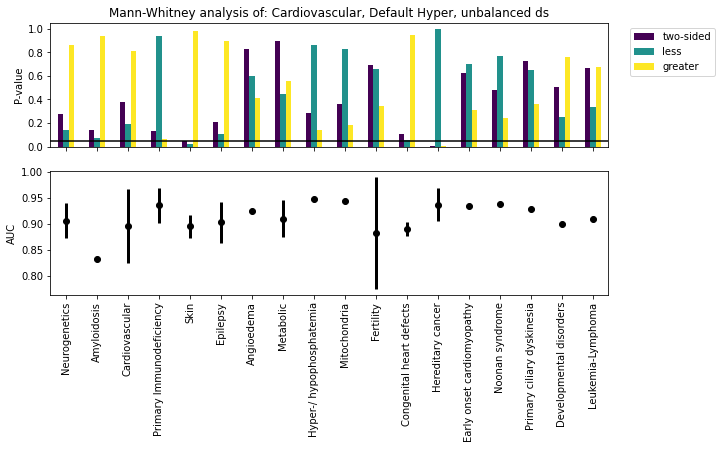

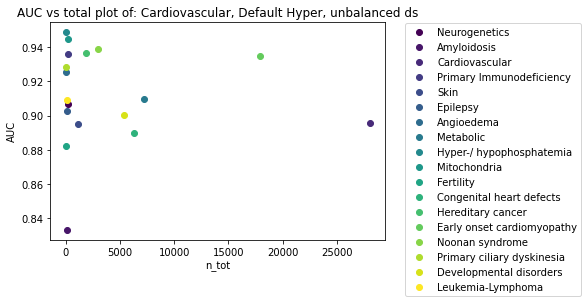

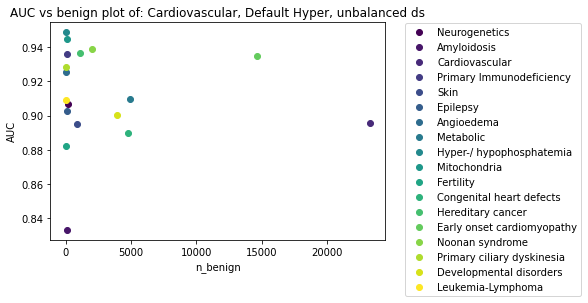

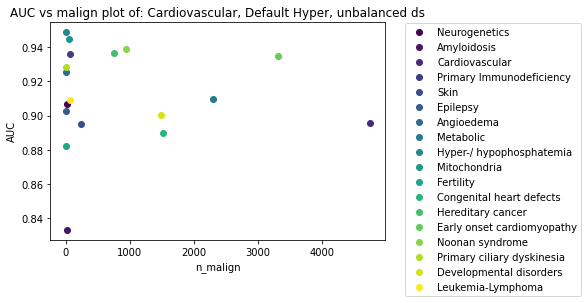

In [3]:
full_auc_analysis(
    curr_setup = 'Cardiovascular, Default Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/default_hyper/cardiovascular/unbalanced/cardiovascular_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/cardiovascular/unbalanced/cardiovascular_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_cardio_unbalanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/cardiovascular/unbalanced/splitted_train_dataset.tsv.gz',
    filter_out='./test_output/model_2_0/default_hyper/cardiovascular/unbalanced/splitted_train_dataset.tsv.gz'
)

 ### Dyslipid | Default hyper | balanced
 [Back](#AUC-analysis-on-Specific-models)

There are 1530 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.6635443999981026
AUC analysis of the testing dataset reveals AUC: 0.5742350055930735
File ./not_saving_directory/auc_analysis_dyslipid_balanced.csv not found, creating.
I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 19%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 38%
I am stilling running, done 42%
I am stilling running, done 47%
I am stilling running, done 52%
I am stilling running, done 57%
I am stilling running, done 62%
I am stilling running, done 67%
I am stilling running, done 72%
I am stilling running, done 77%
I am stilling running, done 83%
I am stilling running, done 88%
I am stilling running, done 94%
I am stilling running, done 99%
Top 10 worst performing genes: 
        gene  auc        f1  recall  fpr  precision n_benign n_ma

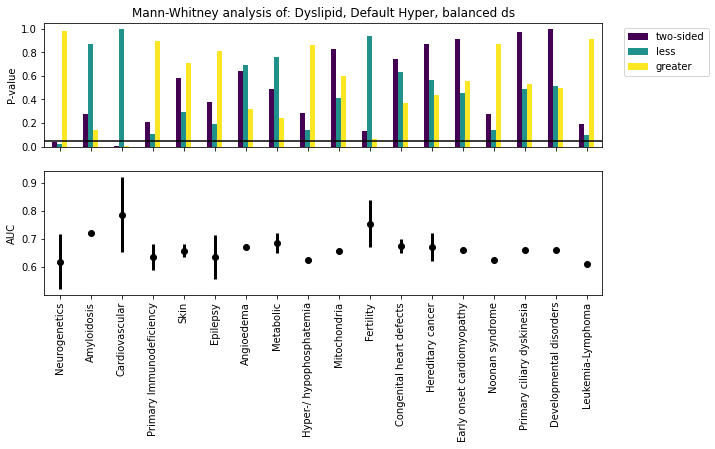

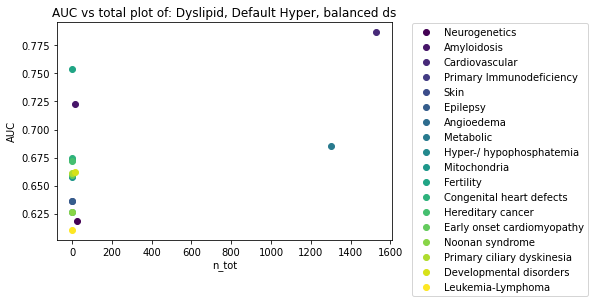

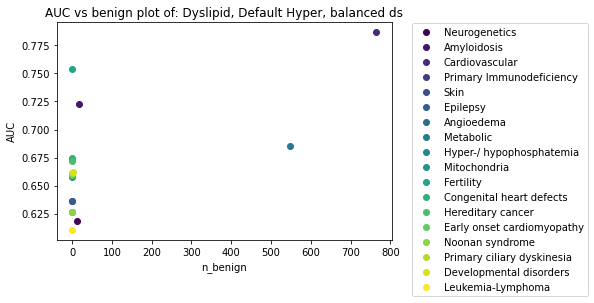

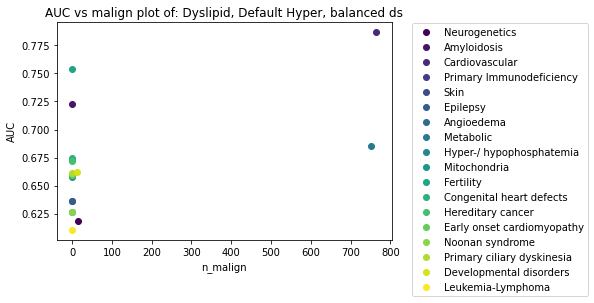

In [21]:
full_auc_analysis(
    curr_setup = 'Dyslipid, Default Hyper, balanced ds',
    train_loc = './test_output/model_2_0/default_hyper/dyslipid/balanced/dyslipid_balanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/dyslipid/balanced/dyslipid_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_dyslipid_balanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/dyslipid/balanced/train_balanced_dataset.tsv.gz',
    filter_out='./datafiles/dyslipid.txt.gz'
)

### Dyslipid | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

There are 5029 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.8353792714855658
AUC analysis of the testing dataset reveals AUC: 0.5906942914443721
File ./not_saving_directory/auc_analysis_dyslipid_unbalanced.csv not found, creating.
I am stilling running, done 4%
I am stilling running, done 8%
I am stilling running, done 13%
I am stilling running, done 17%
I am stilling running, done 22%
I am stilling running, done 26%
I am stilling running, done 31%
I am stilling running, done 35%
I am stilling running, done 40%
I am stilling running, done 45%
I am stilling running, done 50%
I am stilling running, done 55%
I am stilling running, done 60%
I am stilling running, done 66%
I am stilling running, done 71%
I am stilling running, done 76%
I am stilling running, done 81%
I am stilling running, done 86%
I am stilling running, done 92%
I am stilling running, done 97%
Top 10 worst performing genes: 
          gene       auc        f1    recall       fpr  precisi

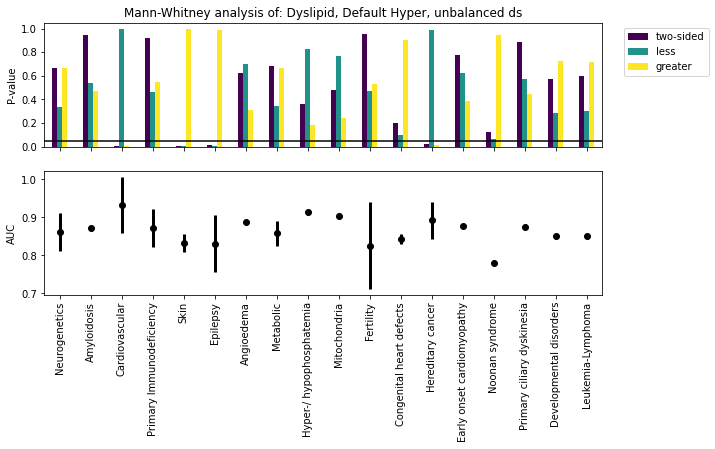

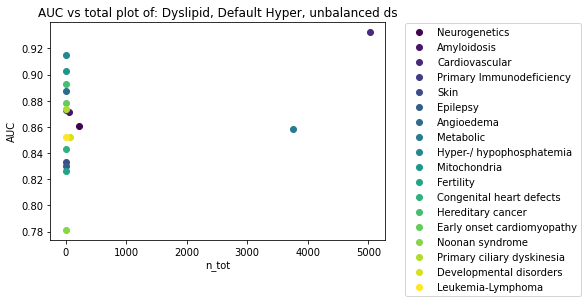

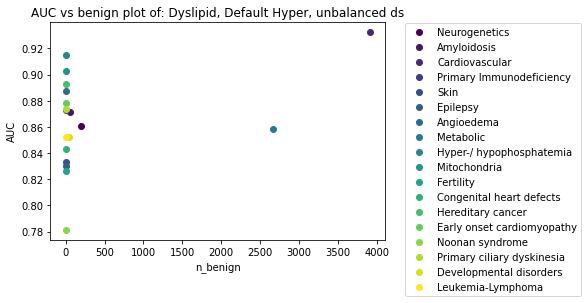

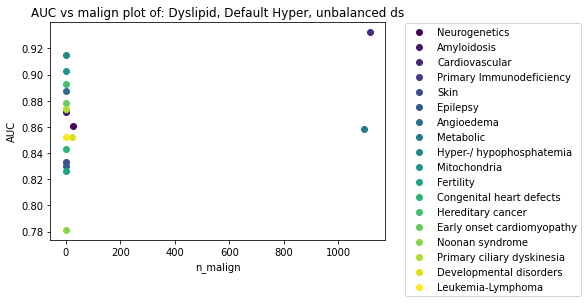

In [22]:
full_auc_analysis(
    curr_setup = 'Dyslipid, Default Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/default_hyper/dyslipid/unbalanced/dyslipid_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/dyslipid/unbalanced/dyslipid_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_dyslipid_unbalanced.csv',
    training_set_loc='./datafiles/dyslipid.txt.gz',
    filter_out='./datafiles/dyslipid.txt.gz'
)

### Hereditary cancer | Default hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

There are 2766 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.7882081912133676
AUC analysis of the testing dataset reveals AUC: 0.7246651191243165
File ./not_saving_directory/auc_analysis_hc_balanced.csv not found, creating.
I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 18%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 38%
I am stilling running, done 43%
I am stilling running, done 49%
I am stilling running, done 54%
I am stilling running, done 60%
I am stilling running, done 66%
I am stilling running, done 71%
I am stilling running, done 77%
I am stilling running, done 83%
I am stilling running, done 89%
I am stilling running, done 95%
Top 10 worst performing genes: 
          gene  auc        f1  recall  fpr  precision n_benign n_malign n_tot  \
2342       AVP  0.0  0.000000     0.0  1.0   0.000000 

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.883425  0.562418  0.441712        all               Neurogenetics   
1    0.943637  0.471818  0.542228        all                 Amyloidosis   
2    0.011012  0.005506  0.994644        all              Cardiovascular   
3    0.503999  0.752123  0.251999        all    Primary Immunodeficiency   
4    0.563678  0.722526  0.281839        all                        Skin   
5    0.798967  0.399484  0.604696        all                    Epilepsy   
6    0.119853  0.944166  0.059926        all                  Angioedema   
7    0.739766  0.636875  0.369883        all                   Metabolic   
8    0.396218  0.811583  0.198109        all    Hyper-/ hypophosphatemia   
9    0.305295  0.855540  0.152647        all                Mitochondria   
10   0.409418  0.204709  0.801095        all                   Fertility   
11   0.167052  0.083526  0.919596        all    

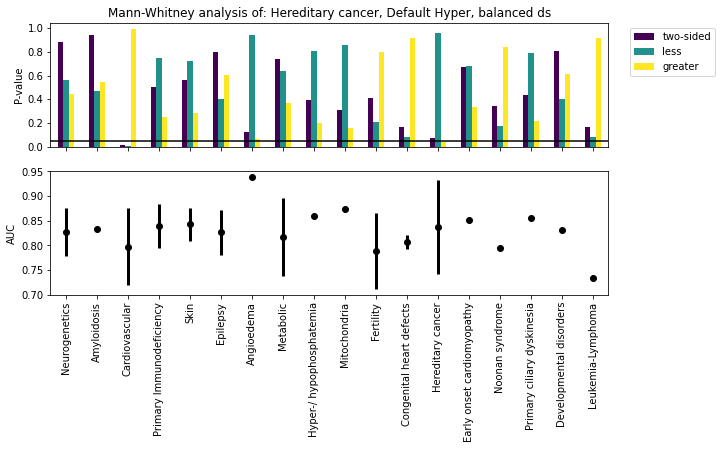

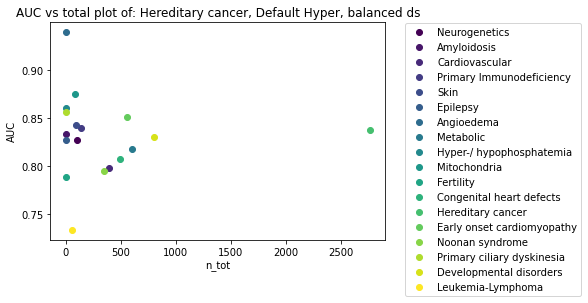

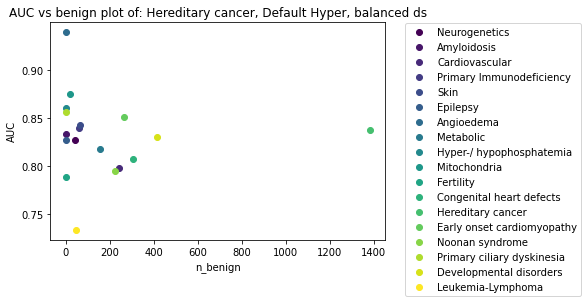

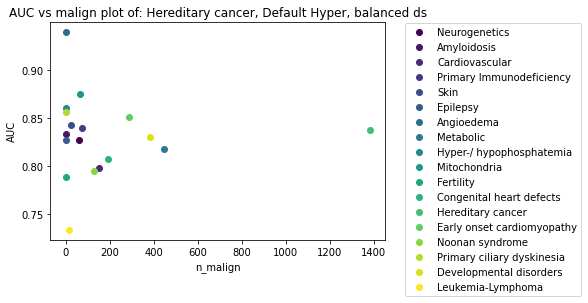

In [4]:
full_auc_analysis(
    curr_setup = 'Hereditary cancer, Default Hyper, balanced ds',
    train_loc = './test_output/model_2_0/default_hyper/ek/balanced/ek_balanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/ek/balanced/ek_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_hc_balanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/ek/balanced/train_balanced_dataset.tsv.gz',
    filter_out='./test_output/model_2_0/default_hyper/ek/unbalanced/splitted_train_dataset.tsv.gz'
)

### Hereditary cancer | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

There are 26776 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.9241746446715966
AUC analysis of the testing dataset reveals AUC: 0.6860944856987427
File ./not_saving_directory/auc_analysis_hc_unbalanced.csv not found, creating.
I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 13%
I am stilling running, done 18%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 39%
I am stilling running, done 44%
I am stilling running, done 50%
I am stilling running, done 56%
I am stilling running, done 62%
I am stilling running, done 68%
I am stilling running, done 73%
I am stilling running, done 79%
I am stilling running, done 85%
I am stilling running, done 91%
I am stilling running, done 97%
Top 10 worst performing genes: 
          gene       auc        f1  recall  fpr  precision n_benign n_malign  \
2275     CDK10  0.000000  0.500000     0.5  0.5   0.

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.564586  0.282293  0.721236        all               Neurogenetics   
1    0.203162  0.101581  0.904554        all                 Amyloidosis   
2    0.315168  0.157584  0.844720        all              Cardiovascular   
3    0.137376  0.933013  0.068688        all    Primary Immunodeficiency   
4    0.090411  0.045205  0.956016        all                        Skin   
5    0.365497  0.182749  0.820108        all                    Epilepsy   
6    0.190893  0.910411  0.095446        all                  Angioedema   
7    0.964197  0.482099  0.525054        all                   Metabolic   
8    0.305295  0.855540  0.152647        all    Hyper-/ hypophosphatemia   
9    0.376834  0.820977  0.188417        all                Mitochondria   
10   0.664955  0.674979  0.332478        all                   Fertility   
11   0.173478  0.086739  0.916474        all    

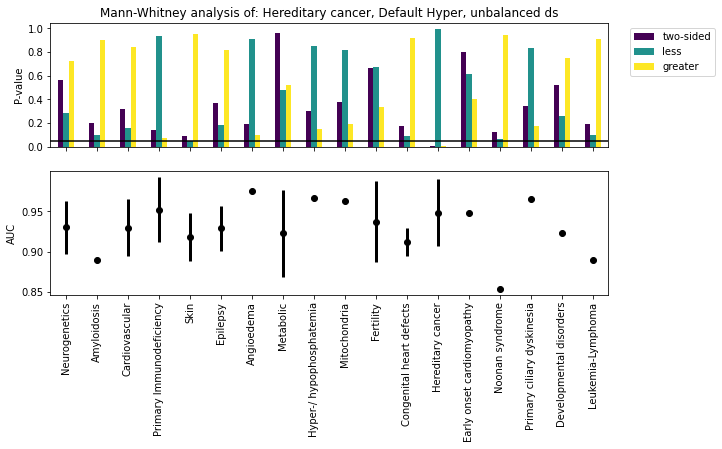

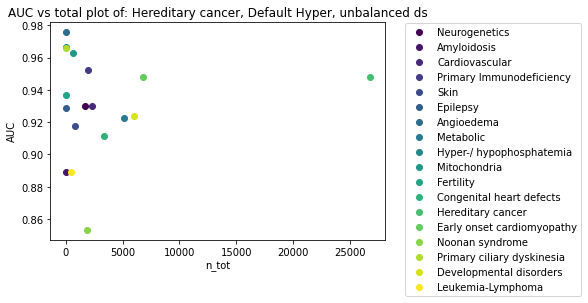

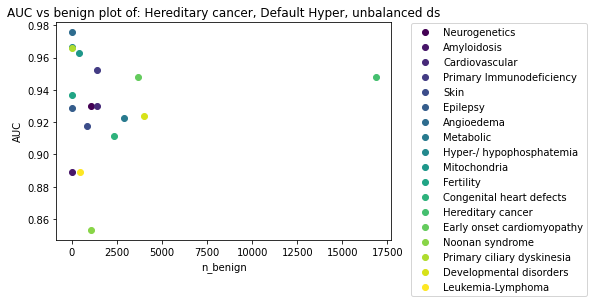

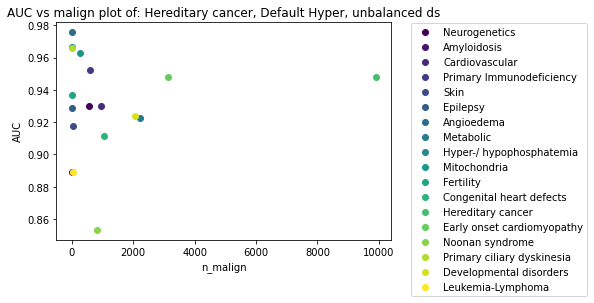

In [6]:
full_auc_analysis(
    curr_setup = 'Hereditary cancer, Default Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/default_hyper/ek/unbalanced/ek_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/ek/unbalanced/ek_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_hc_unbalanced.csv',
    training_set_loc='./datafiles/hereditarycancer.txt.gz',
    filter_out='./test_output/model_2_0/default_hyper/ek/unbalanced/splitted_train_dataset.tsv.gz'
)

### Neurogenetics | Default hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

There are 5804 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.8013512248440763
AUC analysis of the testing dataset reveals AUC: 0.7297721143675924
File ./not_saving_directory/auc_analysis_neuro_balanced.csv not found, creating.
I am stilling running, done 5%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 19%
I am stilling running, done 24%
I am stilling running, done 29%
I am stilling running, done 34%
I am stilling running, done 39%
I am stilling running, done 45%
I am stilling running, done 50%
I am stilling running, done 56%
I am stilling running, done 62%
I am stilling running, done 68%
I am stilling running, done 73%
I am stilling running, done 79%
I am stilling running, done 85%
I am stilling running, done 91%
I am stilling running, done 97%
Top 10 worst performing genes: 
          gene  auc        f1  recall  fpr  precision n_benign n_malign n_tot  \
969       PIGW  0.0  0.857143     1.0  0.0   0.7500

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.012309  0.994025  0.006154        all               Neurogenetics   
1    0.229405  0.892002  0.114702        all                 Amyloidosis   
2    0.292572  0.146286  0.855907        all              Cardiovascular   
3    0.140843  0.931312  0.070421        all    Primary Immunodeficiency   
4    0.850769  0.579695  0.425385        all                        Skin   
5    0.214641  0.894668  0.107320        all                    Epilepsy   
6    0.119853  0.059926  0.944166        all                  Angioedema   
7    0.907093  0.553560  0.453547        all                   Metabolic   
8    0.257973  0.878303  0.128987        all    Hyper-/ hypophosphatemia   
9    0.179177  0.915998  0.089589        all                Mitochondria   
10   0.223698  0.111849  0.892026        all                   Fertility   
11   0.143131  0.071566  0.931208        all    

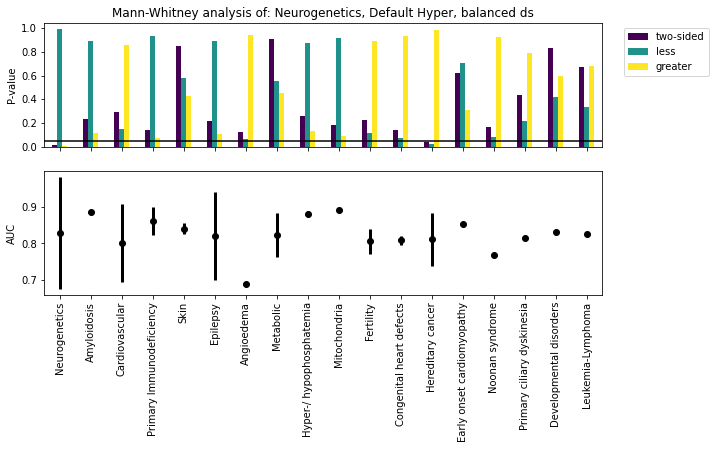

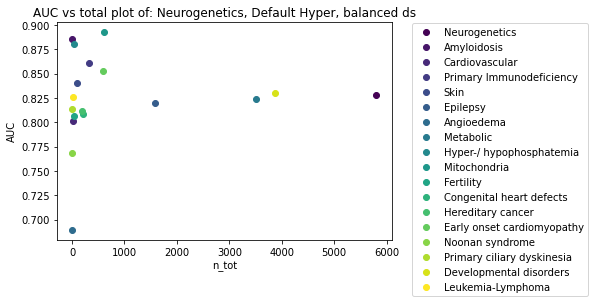

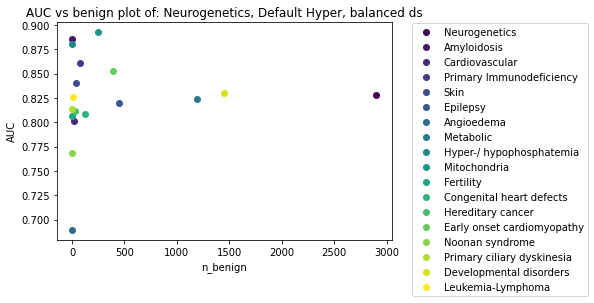

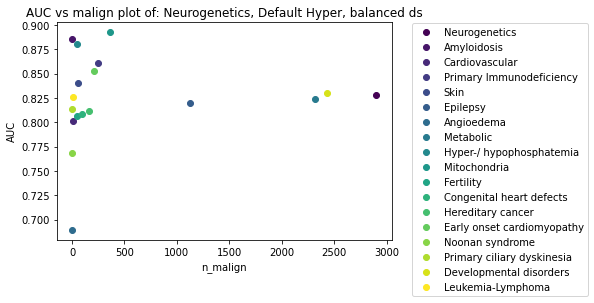

In [7]:
full_auc_analysis(
    curr_setup = 'Neurogenetics, Default Hyper, balanced ds',
    train_loc = './test_output/model_2_0/default_hyper/neuro/balanced/neuro_balanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/neuro/balanced/neuro_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_neuro_balanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/neuro/balanced/train_balanced_dataset.tsv.gz',
    filter_out='./test_output/model_2_0/default_hyper/neuro/unbalanced/splitted_train_dataset.tsv.gz'
)

### Neurogenetics | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

There are 29769 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.9381871874633931
AUC analysis of the testing dataset reveals AUC: 0.6880576676116006
File ./not_saving_directory/auc_analysis_neuro_unbalanced.csv not found, creating.
I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 13%
I am stilling running, done 18%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 38%
I am stilling running, done 44%
I am stilling running, done 50%
I am stilling running, done 56%
I am stilling running, done 61%
I am stilling running, done 67%
I am stilling running, done 73%
I am stilling running, done 79%
I am stilling running, done 85%
I am stilling running, done 91%
I am stilling running, done 96%
Top 10 worst performing genes: 
          gene       auc        f1  recall  fpr  precision n_benign n_malign  \
2241    UBQLN2  0.000000  0.000000     0.0  1.0  

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.240783  0.881696  0.120391        all               Neurogenetics   
1    0.376834  0.188417  0.820977        all                 Amyloidosis   
2    0.148014  0.074007  0.927330        all              Cardiovascular   
3    0.167022  0.918464  0.083511        all    Primary Immunodeficiency   
4    0.109065  0.054532  0.946886        all                        Skin   
5    0.151007  0.075504  0.926026        all                    Epilepsy   
6    0.229405  0.114702  0.892002        all                  Angioedema   
7    0.596344  0.298172  0.708023        all                   Metabolic   
8    0.436748  0.791904  0.218374        all    Hyper-/ hypophosphatemia   
9    0.595941  0.714166  0.297970        all                Mitochondria   
10   0.186879  0.909957  0.093440        all                   Fertility   
11   0.137583  0.068792  0.933899        all    

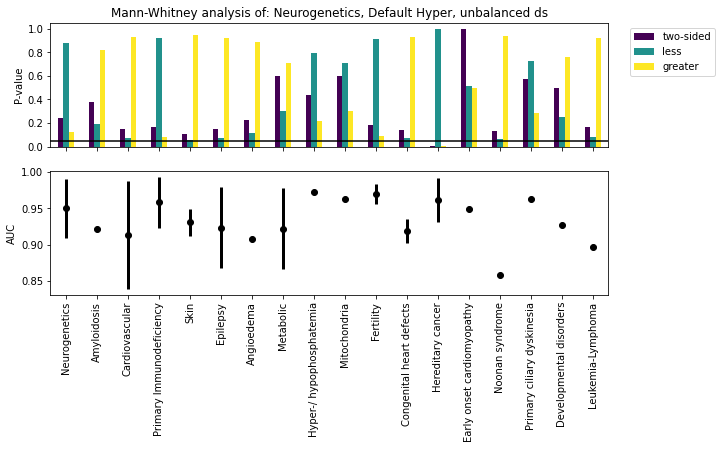

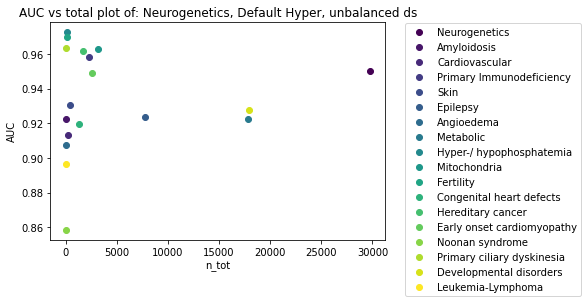

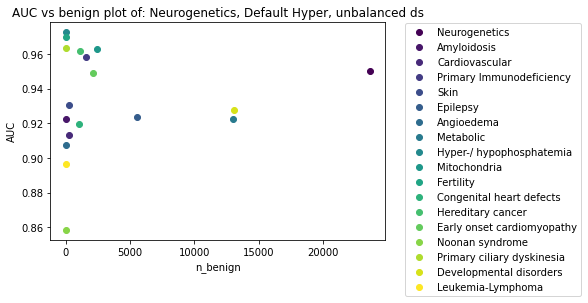

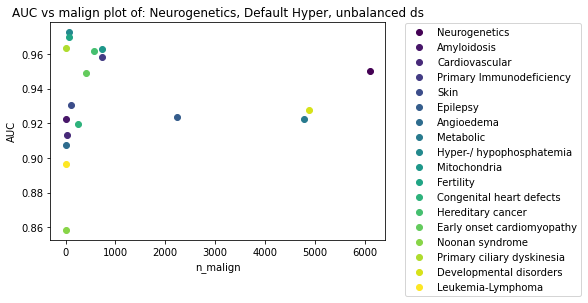

In [9]:
full_auc_analysis(
    curr_setup = 'Neurogenetics, Default Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/default_hyper/neuro/unbalanced/neuro_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/default_hyper/neuro/unbalanced/neuro_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_neuro_unbalanced.csv',
    training_set_loc='./datafiles/neurogenetics.txt.gz',
    filter_out='./test_output/model_2_0/default_hyper/neuro/unbalanced/splitted_train_dataset.tsv.gz'
)

### Cardiovascular | Optimal hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.07549633411939431
Parameter n_estimators is set to 460
Parameter max_depth is set to 14
There are 6642 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.7603057057313227
AUC analysis of the testing dataset reveals AUC: 0.6703142530460753
File ./not_saving_directory/auc_analysis_randomhyper_cardio_balanced.csv found. Loading.
Top 10 worst performing genes: 
          gene  auc        f1  recall  fpr  precision  n_benign  n_malign  \
1977      INTU  0.0  0.857143     1.0  0.0   0.750000         1         3   
2318       PTH  0.0  0.000000     0.0  1.0   0.000000         3         1   
1716      FAR1  0.0  0.666667     1.0  0.0   0.500000         1         1   
2288     TEX15  0.0  0.000000     0.0  1.0   0.000000         3         1   
2112    SLC6A9  0.0  0.666667     1.0  0.0   0.500000         2         2   
1549      CSTA  0.0  0.666667     1.0  0.0   0.500000         1         1   
805      CALM3  0.0  0.571429     1

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.489402  0.244701  0.758577        all               Neurogenetics   
1    0.376828  0.188414  0.820980        all                 Amyloidosis   
2    0.600382  0.703144  0.300191        all              Cardiovascular   
3    0.187846  0.908233  0.093923        all    Primary Immunodeficiency   
4    0.673250  0.668098  0.336625        all                        Skin   
5    0.444831  0.222416  0.780800        all                    Epilepsy   
6    0.119848  0.944168  0.059924        all                  Angioedema   
7    0.935603  0.467802  0.539333        all                   Metabolic   
8    0.190887  0.910414  0.095443        all    Hyper-/ hypophosphatemia   
9    0.243389  0.885301  0.121694        all                Mitochondria   
10   0.563636  0.281818  0.725104        all                   Fertility   
11   0.885214  0.442607  0.565522        all    

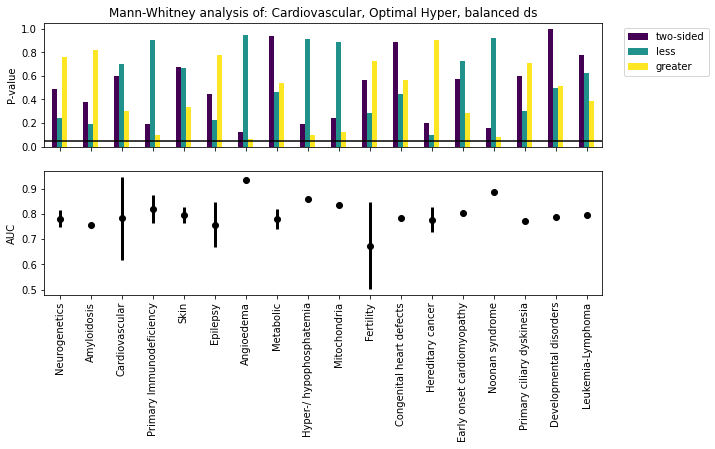

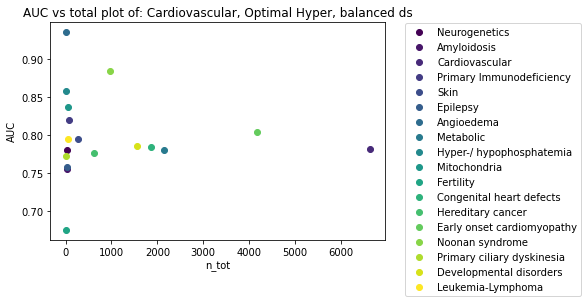

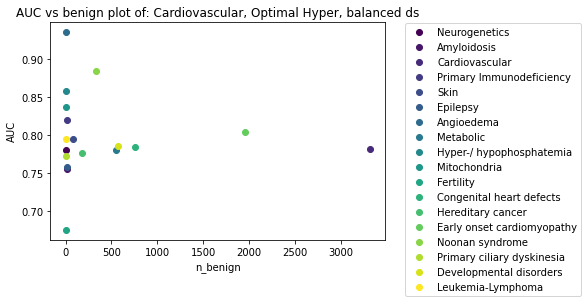

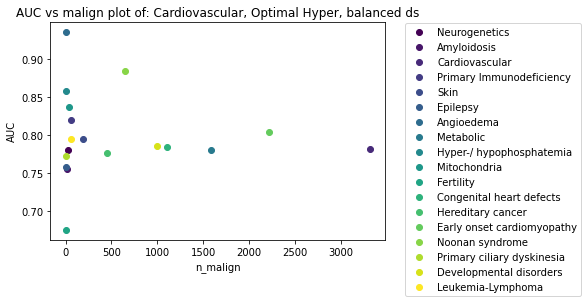

In [3]:
full_auc_analysis(
    curr_setup = 'Cardiovascular, Optimal Hyper, balanced ds',
    train_loc = './test_output/model_2_0/random_hyper/cardiovascular/balanced/cardiovascular_balanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/cardiovascular/balanced/cardiovascular_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_cardio_balanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz',
    model='./test_output/model_2_0/random_hyper/cardiovascular/balanced/xgb_optimal_model.pickle.dat',
    filter_out='./test_output/model_2_0/default_hyper/cardiovascular/unbalanced/splitted_train_dataset.tsv.gz'
)

### Cardiovascular | Optimal hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.1467122152765178
Parameter n_estimators is set to 222
Parameter max_depth is set to 9
There are 35058 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.8960473563876927
AUC analysis of the testing dataset reveals AUC: 0.6551261140846805
File ./not_saving_directory/auc_analysis_randomhyper_cardio_unbalanced.csv found. Loading.
Top 10 worst performing genes: 
          gene       auc        f1  recall  fpr  precision  n_benign  \
2172      SAA1  0.000000  0.000000     0.0  1.0   0.000000        61   
1993      FAR1  0.000000  0.666667     1.0  0.0   0.500000         1   
1510     PTHLH  0.000000  0.285714     1.0  0.0   0.166667         5   
2277     CDK10  0.000000  0.500000     0.5  0.5   0.500000         1   
2282  TRAF3IP1  0.000000  0.000000     0.0  1.0   0.000000         3   
2195    MRPS34  0.000000  0.800000     1.0  0.0   0.666667         1   
287      ASCC1  0.015873  0.000000     0.0  1.0   0.000000        63 

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.384681  0.192341  0.810510        all               Neurogenetics   
1    0.137624  0.068812  0.935750        all                 Amyloidosis   
2    0.762062  0.381031  0.622626        all              Cardiovascular   
3    0.070293  0.965848  0.035147        all    Primary Immunodeficiency   
4    0.049331  0.024666  0.976075        all                        Skin   
5    0.177245  0.088623  0.913105        all                    Epilepsy   
6    0.671421  0.677080  0.335710        all                  Angioedema   
7    0.739766  0.369883  0.636875        all                   Metabolic   
8    0.243393  0.885298  0.121697        all    Hyper-/ hypophosphatemia   
9    0.723714  0.651306  0.361857        all                Mitochondria   
10   0.852753  0.581694  0.426376        all                   Fertility   
11   0.103267  0.051633  0.950512        all    

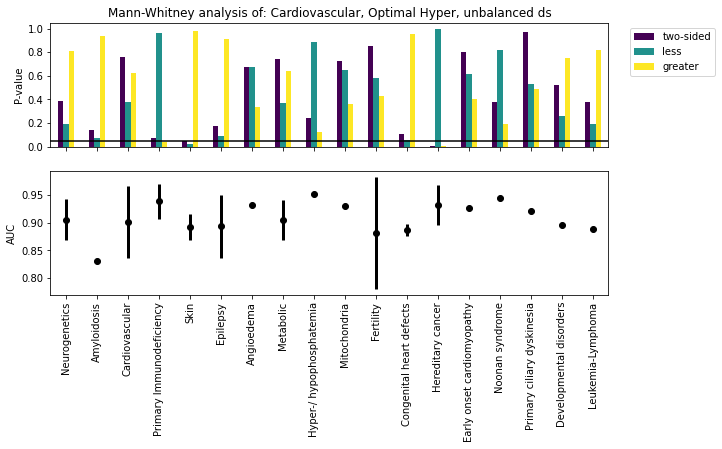

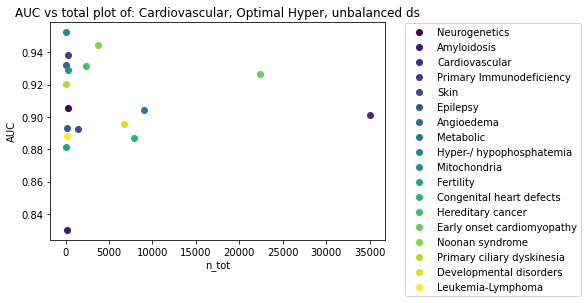

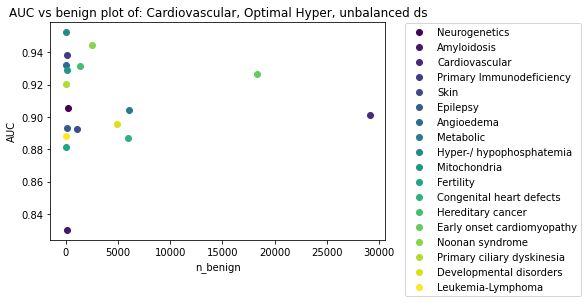

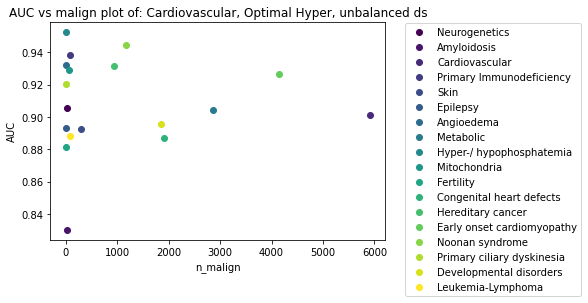

In [4]:
full_auc_analysis(
    curr_setup = 'Cardiovascular, Optimal Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/random_hyper/cardiovascular/unbalanced/cardiovascular_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/cardiovascular/unbalanced/cardiovascular_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_cardio_unbalanced.csv',
    training_set_loc='./datafiles/cardiovascular.txt.gz',
    model='./test_output/model_2_0/random_hyper/cardiovascular/unbalanced/xgb_optimal_model.pickle.dat',
    filter_out='./test_output/model_2_0/default_hyper/cardiovascular/unbalanced/splitted_train_dataset.tsv.gz'
)

### Dyslipid | Optimal hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.1527244637312314
Parameter n_estimators is set to 211
Parameter max_depth is set to 10
There are 1530 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.7188298851914152
AUC analysis of the testing dataset reveals AUC: 0.5654116356142449
File ./not_saving_directory/auc_analysis_randomhyper_dyslipid_balanced.csv found. Loading.
Top 10 worst performing genes: 
        gene  auc        f1  recall  fpr  precision  n_benign  n_malign  \
813     ZIC1  0.0  0.500000     1.0  0.0   0.333333         2         1   
2026  KISS1R  0.0  0.250000     1.0  0.0   0.142857         6         1   
1456  GTF2H5  0.0  0.400000     1.0  0.0   0.250000         3         1   
1095   SPG21  0.0  0.666667     1.0  0.0   0.500000         1         1   
2337  AKR1D1  0.0  0.000000     0.0  1.0   0.000000         9         2   
2339    SORD  0.0  0.500000     1.0  0.0   0.333333         2         1   
2257    PBX1  0.0  0.666667     1.0  0.0   0.500

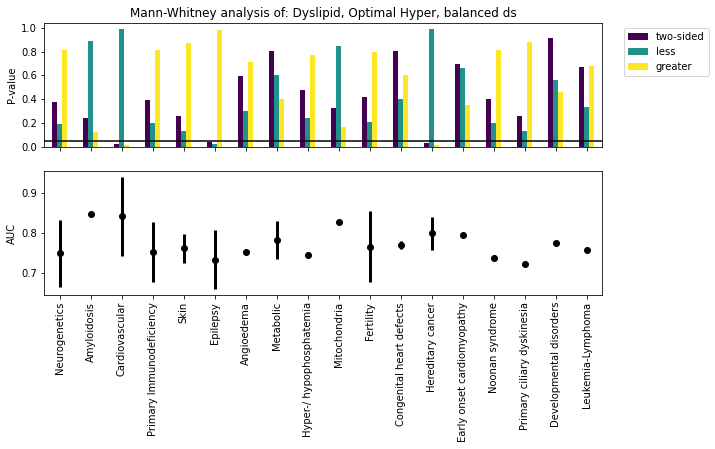

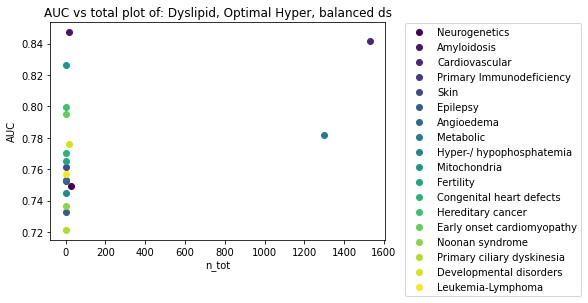

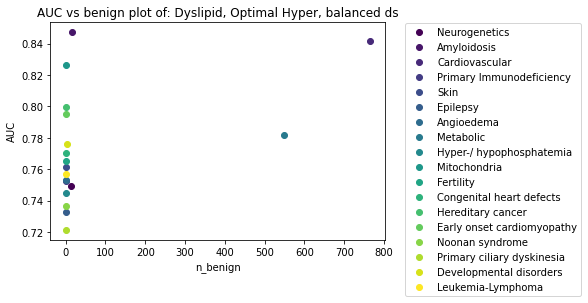

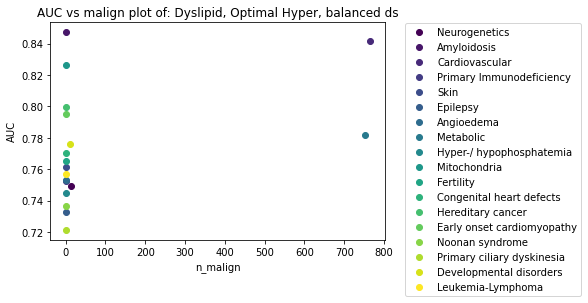

In [5]:
full_auc_analysis(
    curr_setup = 'Dyslipid, Optimal Hyper, balanced ds',
    train_loc = './test_output/model_2_0/random_hyper/dyslipid/balanced/dyslipid_balanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/dyslipid/balanced/dyslipid_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_dyslipid_balanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/dyslipid/balanced/train_balanced_dataset.tsv.gz',
    model='./test_output/model_2_0/random_hyper/dyslipid/balanced/xgb_optimal_model.pickle.dat',
    filter_out='./datafiles/dyslipid.txt.gz'
)

### Dyslipid | Optimal hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.15442510030625153
Parameter n_estimators is set to 257
Parameter max_depth is set to 17
There are 5029 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.8428616243655226
AUC analysis of the testing dataset reveals AUC: 0.5908200773253944
File ./not_saving_directory/auc_analysis_randomhyper_dyslipid_unbalanced.csv found. Loading.
Top 10 worst performing genes: 
          gene       auc        f1    recall       fpr  precision  n_benign  \
2353        F2  0.000000  0.000000  0.000000  1.000000   0.000000         2   
1748  KIAA0556  0.000000  0.666667  1.000000  0.000000   0.500000         1   
899      PTHLH  0.000000  0.285714  1.000000  0.000000   0.166667         5   
240   KIAA0196  0.000000  0.000000  0.000000  1.000000   0.000000       306   
2320     AP1S2  0.000000  0.000000  0.000000  1.000000   0.000000         2   
2154      FAR1  0.000000  0.666667  1.000000  0.000000   0.500000         1   
1882      INTU  0

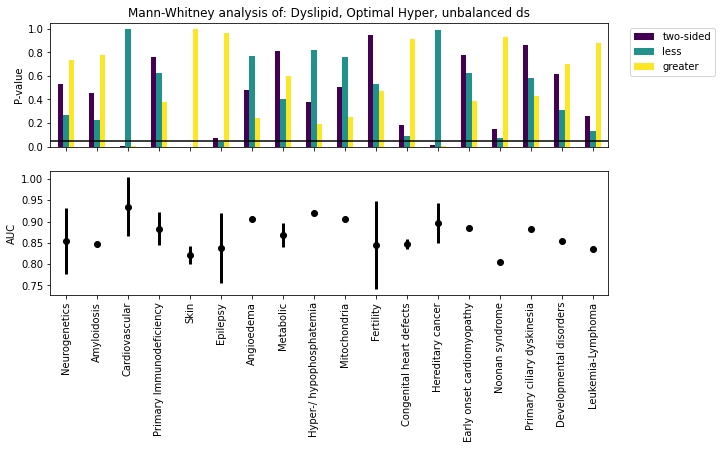

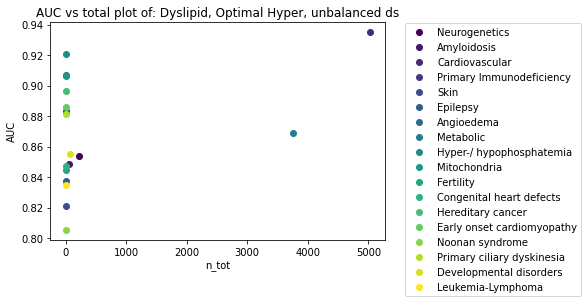

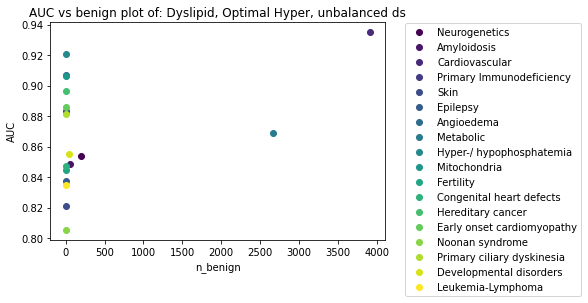

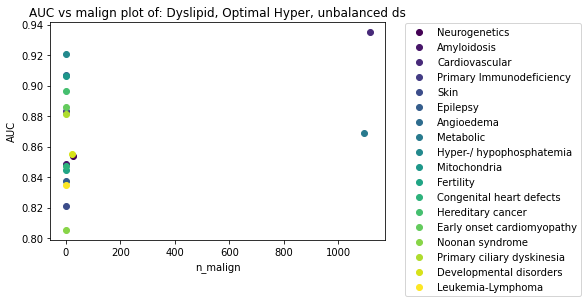

In [6]:
full_auc_analysis(
    curr_setup = 'Dyslipid, Optimal Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/random_hyper/dyslipid/unbalanced/dyslipid_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/dyslipid/unbalanced/dyslipid_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_dyslipid_unbalanced.csv',
    training_set_loc='./datafiles/dyslipid.txt.gz',
    model='./test_output/model_2_0/random_hyper/dyslipid/unbalanced/xgb_optimal_model.pickle.dat',
    filter_out='./datafiles/dyslipid.txt.gz'
)

### Hereditary cancer | Optimal hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.10027603273002453
Parameter n_estimators is set to 268
Parameter max_depth is set to 9
There are 2766 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.7931771487711897
AUC analysis of the testing dataset reveals AUC: 0.7264596223919082
File ./not_saving_directory/auc_analysis_randomhyper_ek_balanced.csv found. Loading.
Top 10 worst performing genes: 
         gene  auc        f1  recall  fpr  precision  n_benign  n_malign  \
2342      AVP  0.0  0.000000     0.0  1.0   0.000000         1         1   
2316    HPSE2  0.0  0.333333     1.0  0.0   0.200000         4         1   
894    SLC6A9  0.0  0.666667     1.0  0.0   0.500000         2         2   
487      PIGW  0.0  0.857143     1.0  0.0   0.750000         1         3   
1048    ERMAP  0.0  0.000000     0.0  1.0   0.000000        21         1   
1822  ANKRD17  0.0  0.666667     1.0  0.0   0.500000         1         1   
2146   MRPS34  0.0  0.800000     1.0  0.0   0.6

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.522899  0.261449  0.741946        all               Neurogenetics   
1    0.547875  0.737708  0.273938        all                 Amyloidosis   
2    0.081064  0.040532  0.960298        all              Cardiovascular   
3    0.256245  0.874575  0.128123        all    Primary Immunodeficiency   
4    0.608293  0.700378  0.304146        all                        Skin   
5    0.060064  0.030032  0.970699        all                    Epilepsy   
6    0.147242  0.931187  0.073621        all                  Angioedema   
7    0.780783  0.616482  0.390392        all                   Metabolic   
8    0.288920  0.863427  0.144460        all    Hyper-/ hypophosphatemia   
9    0.243395  0.885298  0.121697        all                Mitochondria   
10   0.265434  0.871658  0.132717        all                   Fertility   
11   0.143131  0.071566  0.931208        all    

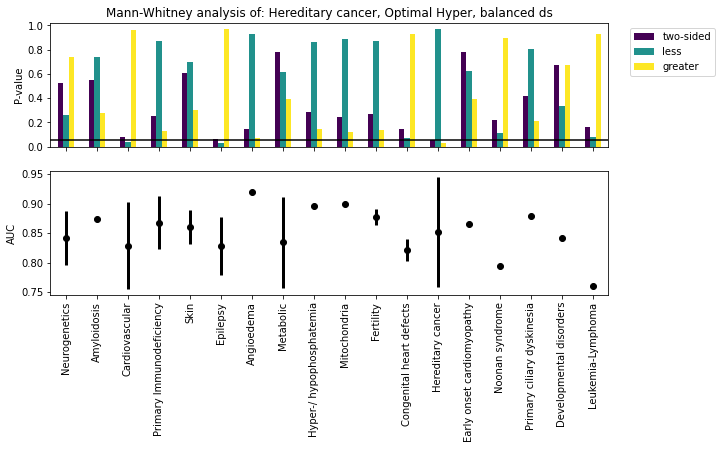

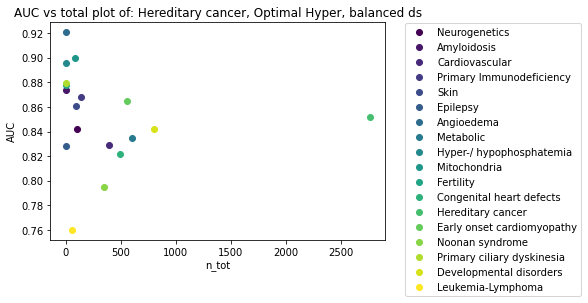

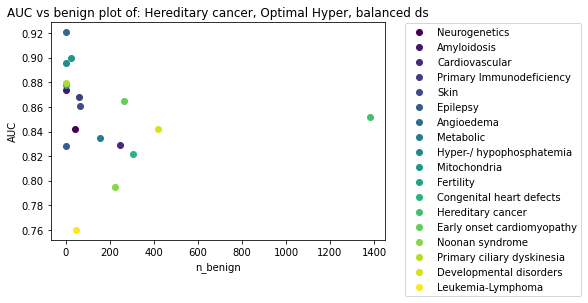

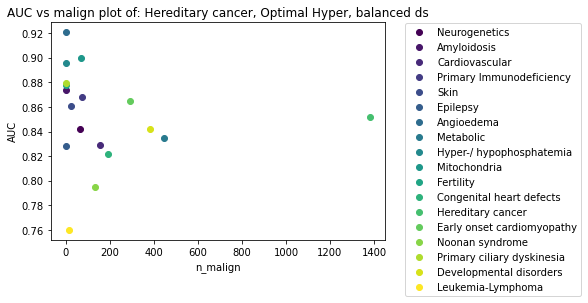

In [7]:
full_auc_analysis(
    curr_setup = 'Hereditary cancer, Optimal Hyper, balanced ds',
    train_loc = './test_output/model_2_0/random_hyper/ek/balanced/ek_balanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/ek/balanced/ek_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_ek_balanced.csv',
    model='./test_output/model_2_0/random_hyper/ek/balanced/xgb_ransearch.pickle.dat',
    training_set_loc='./test_output/model_2_0/default_hyper/ek/balanced/train_balanced_dataset.tsv.gz',
    filter_out='./test_output/model_2_0/default_hyper/ek/unbalanced/splitted_train_dataset.tsv.gz'
)

### Hereditary cancer | Optimal hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.11829773260174394
Parameter n_estimators is set to 541
Parameter max_depth is set to 16
There are 26776 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.9229124513299454
AUC analysis of the testing dataset reveals AUC: 0.6842662092708873
File ./not_saving_directory/auc_analysis_randomhyper_ek_unbalanced.csv found. Loading.
Top 10 worst performing genes: 
          gene       auc        f1  recall  fpr  precision  n_benign  \
1776      SAA1  0.000000  0.000000     0.0  1.0   0.000000        61   
1995     PTHLH  0.000000  0.285714     1.0  0.0   0.166667         5   
2270     CDK10  0.000000  0.500000     0.5  0.5   0.500000         1   
2336  TRAF3IP1  0.000000  0.000000     0.0  1.0   0.000000         3   
246      ASCC1  0.031746  0.000000     0.0  1.0   0.000000        63   
1156    ABCA13  0.064103  0.026667     1.0  0.0   0.013514        78   
499    C12orf4  0.090909  0.086957     1.0  0.0   0.045455        22   

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.586013  0.293007  0.710585        all               Neurogenetics   
1    0.243395  0.121697  0.885298        all                 Amyloidosis   
2    0.202817  0.101408  0.900285        all              Cardiovascular   
3    0.124162  0.939490  0.062081        all    Primary Immunodeficiency   
4    0.140843  0.070421  0.931312        all                        Skin   
5    0.316113  0.158056  0.844545        all                    Epilepsy   
6    0.190893  0.910411  0.095446        all                  Angioedema   
7    0.878702  0.439351  0.567719        all                   Metabolic   
8    0.376834  0.820977  0.188417        all    Hyper-/ hypophosphatemia   
9    0.396218  0.811583  0.198109        all                Mitochondria   
10   0.664955  0.674979  0.332478        all                   Fertility   
11   0.223698  0.111849  0.892026        all    

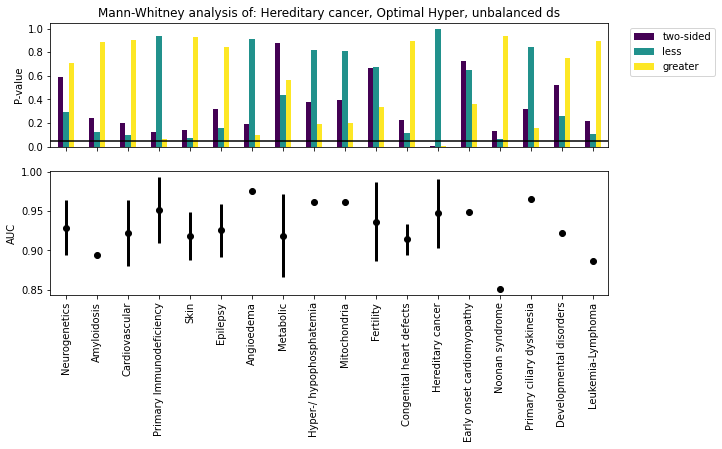

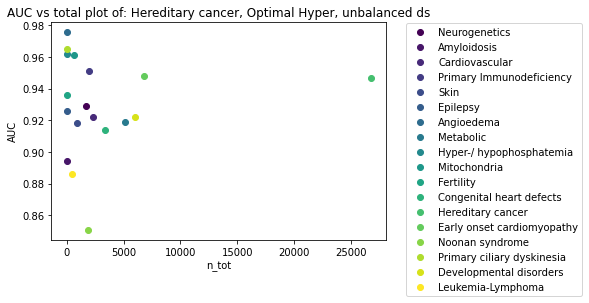

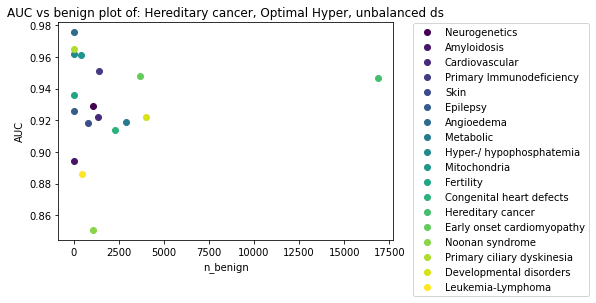

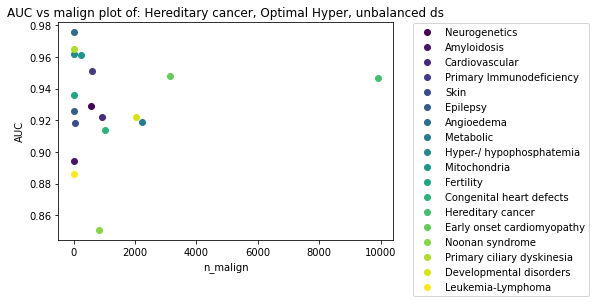

In [8]:
full_auc_analysis(
    curr_setup = 'Hereditary cancer, Optimal Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/random_hyper/ek/unbalanced/ek_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/ek/unbalanced/ek_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_ek_unbalanced.csv',
    training_set_loc='./datafiles/hereditarycancer.txt.gz',
    model='./test_output/model_2_0/random_hyper/ek/unbalanced/xgb_optimal_model.pickle.dat',
    filter_out='./test_output/model_2_0/default_hyper/ek/unbalanced/splitted_train_dataset.tsv.gz'
)

### Neurogenetics | Optimal hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.0957402972203567
Parameter n_estimators is set to 352
Parameter max_depth is set to 10
There are 5804 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.8022959538708234
AUC analysis of the testing dataset reveals AUC: 0.7219954741583261
File ./not_saving_directory/auc_analysis_randomhyper_neuro_balanced.csv found. Loading.
Top 10 worst performing genes: 
          gene  auc        f1  recall  fpr  precision  n_benign  n_malign  \
2252      EFHB  0.0  0.000000     0.0  1.0   0.000000         1         1   
1453      FAR1  0.0  0.666667     1.0  0.0   0.500000         1         1   
41       ASCC1  0.0  0.030769     1.0  0.0   0.015625        63         1   
1563      ANK3  0.0  0.000000     0.0  1.0   0.000000       110         1   
2196     MPZL2  0.0  0.666667     1.0  0.0   0.500000         1         1   
2191  TRAF3IP1  0.0  0.000000     0.0  1.0   0.000000         3         1   
1337      SMPX  0.0  0.285714     1.0

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.003974  0.998078  0.001987        all               Neurogenetics   
1    0.943637  0.542228  0.471818        all                 Amyloidosis   
2    0.379140  0.189570  0.813024        all              Cardiovascular   
3    0.240301  0.882428  0.120150        all    Primary Immunodeficiency   
4    0.932788  0.466394  0.538761        all                        Skin   
5    0.290664  0.857128  0.145332        all                    Epilepsy   
6    0.119853  0.059926  0.944166        all                  Angioedema   
7    0.794599  0.609608  0.397299        all                   Metabolic   
8    0.215997  0.898419  0.107998        all    Hyper-/ hypophosphatemia   
9    0.190893  0.910411  0.095446        all                Mitochondria   
10   0.256685  0.128342  0.875931        all                   Fertility   
11   0.126986  0.063493  0.939035        all    

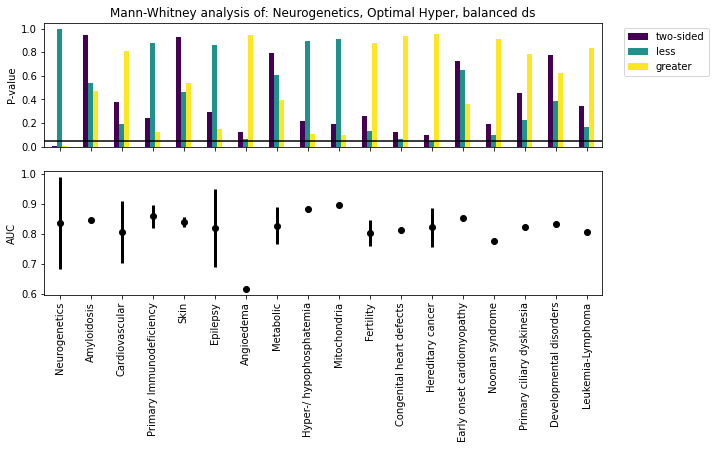

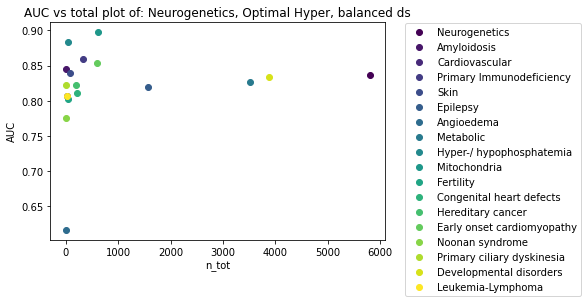

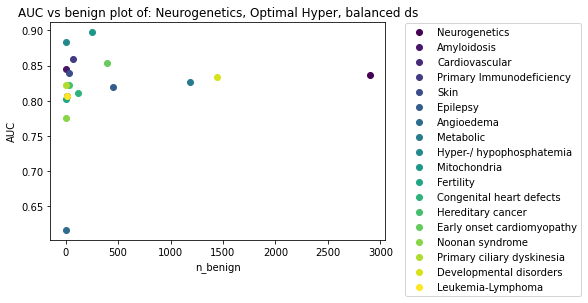

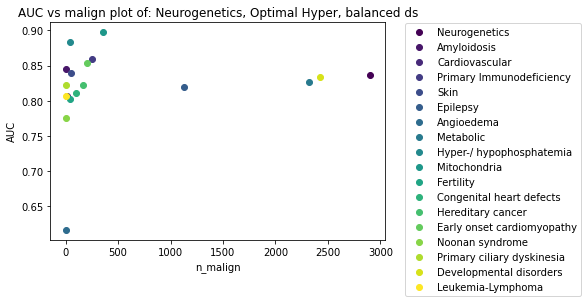

In [9]:
full_auc_analysis(
    curr_setup = 'Neurogenetics, Optimal Hyper, balanced ds',
    train_loc = './test_output/model_2_0/random_hyper/neuro/balanced/neuro_balanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/neuro/balanced/neuro_balanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_neuro_balanced.csv',
    training_set_loc='./test_output/model_2_0/default_hyper/neuro/balanced/train_balanced_dataset.tsv.gz',
    model='./test_output/model_2_0/random_hyper/neuro/balanced/xgb_optimal_model.pickle.dat',
    filter_out='./test_output/model_2_0/default_hyper/neuro/unbalanced/splitted_train_dataset.tsv.gz'
)

### Neurogenetics | Optimal hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

Parameter learning_rate is set to 0.09900765886072124
Parameter n_estimators is set to 248
Parameter max_depth is set to 18
There are 29769 samples in the training set.
AUC analysis of the training dataset reveals AUC: 0.9371396364066774
AUC analysis of the testing dataset reveals AUC: 0.6843054780134005
File ./not_saving_directory/auc_analysis_randomhyper_neuro_unbalanced.csv found. Loading.
Top 10 worst performing genes: 
          gene       auc        f1  recall  fpr  precision  n_benign  \
2242  TRAF3IP1  0.000000  0.000000     0.0  1.0   0.000000         3   
867      PTHLH  0.000000  0.285714     1.0  0.0   0.166667         5   
12       ASCC1  0.015873  0.000000     0.0  1.0   0.000000        63   
1822      SAA1  0.049180  0.000000     0.0  1.0   0.000000        61   
2153       TNC  0.070671  0.000000     0.0  1.0   0.000000       283   
632      ERMAP  0.095238  0.000000     0.0  1.0   0.000000        21   
1329     KITLG  0.142857  0.000000     0.0  1.0   0.000000        21

/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/utilities.py:429: RuntimeWarning: Mean of empty slice.
  x_mean = x.mean()
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


UMCG genepanels Mann-Whitney analysis: 
    two-sided      less   greater category_x                 compared_to  \
0    0.351263  0.827061  0.175632        all               Neurogenetics   
1    0.203162  0.101581  0.904554        all                 Amyloidosis   
2    0.122904  0.061452  0.939706        all              Cardiovascular   
3    0.187852  0.908230  0.093926        all    Primary Immunodeficiency   
4    0.098064  0.049032  0.952271        all                        Skin   
5    0.191576  0.095788  0.906042        all                    Epilepsy   
6    0.457878  0.228939  0.781626        all                  Angioedema   
7    0.621479  0.310739  0.695573        all                   Metabolic   
8    0.416192  0.801891  0.208096        all    Hyper-/ hypophosphatemia   
9    0.547875  0.737708  0.273938        all                Mitochondria   
10   0.201030  0.903070  0.100515        all                   Fertility   
11   0.143131  0.071566  0.931208        all    

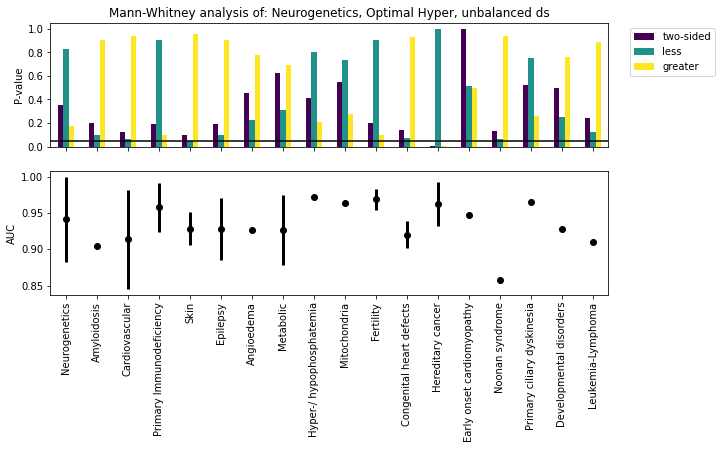

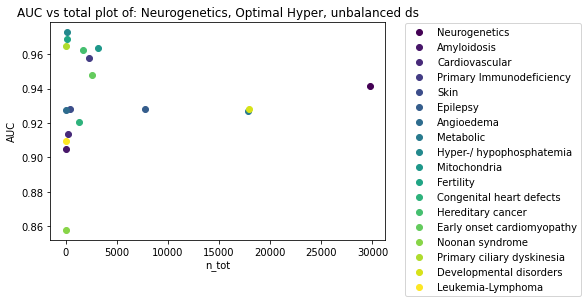

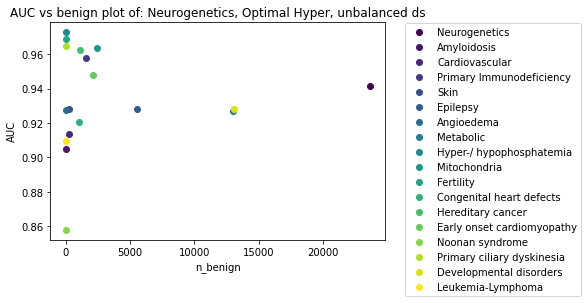

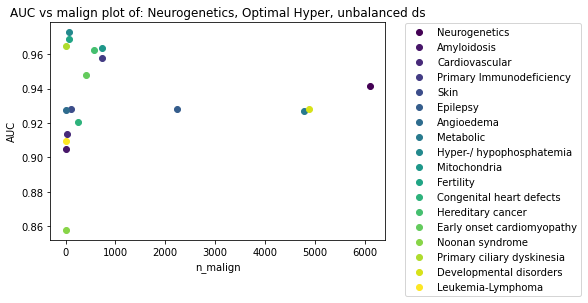

In [10]:
full_auc_analysis(
    curr_setup = 'Neurogenetics, Optimal Hyper, unbalanced ds',
    train_loc = './test_output/model_2_0/random_hyper/neuro/unbalanced/neuro_unbalanced_train.txt',
    test_loc = './test_output/model_2_0/random_hyper/neuro/unbalanced/neuro_unbalanced_test.txt',
    auc_analysis_name= 'auc_analysis_randomhyper_neuro_unbalanced.csv',
    training_set_loc='./datafiles/neurogenetics.txt.gz',
    model='./test_output/model_2_0/random_hyper/neuro/unbalanced/xgb_optimal_model.pickle.dat',
    filter_out='./test_output/model_2_0/default_hyper/neuro/unbalanced/splitted_train_dataset.tsv.gz'
)

# AUC vs n_samples analysis
[Index](#Index)

In [2]:
# Subprocess calling of the incrementing model creations.

location = os.path.join(os.path.abspath('.'))
types = ['balanced', 'unbalanced']
categories = ['cardio', 'dyslipid', 'hc', 'neuro']
unbalanced_train_loc = {
    "cardio": 'cardiovascular.txt.gz',
    'dyslipid': 'dyslipid.txt.gz',
    'hc': 'hereditarycancer.txt.gz',
    'neuro': 'neurogenetics.txt.gz'
}
specified_defaults = {
    'cardio':{
        'balanced': os.path.join(location, 'not_saving_directory', 'cardiovascular_balanced.json'),
        'unbalanced': os.path.join(location, 'not_saving_directory', 'cardiovascular_unbalanced.json')
    },
    'dyslipid':{
        'balanced': os.path.join(location, 'not_saving_directory', 'dyslipid_balanced.json'),
        'unbalanced': os.path.join(location, 'not_saving_directory', 'dyslipid_unbalanced.json')   
    },
    'hc':{
        'balanced': os.path.join(location, 'not_saving_directory', 'ek_balanced.json'),
        'unbalanced': os.path.join(location, 'not_saving_directory', 'ek_unbalanced.json')
    },
    'neuro':{
        'balanced': os.path.join(location, 'not_saving_directory', 'neuro_balanced.json'),
        'unbalanced': os.path.join(location, 'not_saving_directory', 'neuro_unbalanced.json')
    }
}
attempts = ['attempt_2', 'attempt_3']
levels = np.arange(10,100, 10)
level = np.round_(np.arange(0.1,1,0.1), decimals=2)
for tipe in types:
    for category in categories:
        specified_d = specified_defaults[category][tipe]
        if tipe == 'balanced':
            input_loc = os.path.join(location, 'output_incrementing_models', tipe, category, 'train_balanced_dataset.tsv.gz')
        else:
            input_loc = os.path.join(location, 'datafiles', unbalanced_train_loc[category])
        for i in range(9):
            folder = str(levels[i])
            percentage = str(level[i])
            for attempt in attempts:
                output_loc = os.path.join(location, 'output_incrementing_models', tipe, category, folder, attempt)
                if not os.path.isfile(os.path.join(output_loc, 'splitted_test_dataset.tsv.gz')):
                    command = f'python3 /home/rjsietsma/PycharmProjects/train_capice_model/train_model.py -b {input_loc} -o {output_loc} -s {percentage} -v -d -sd {specified_d}'
                    print(f"Calling: {command}")
                    subprocess.call(command.split(' '))

In [3]:
for path in Path('./').rglob('attempt_*'):
    if not os.path.isfile(os.path.join(path, 'test_results.txt')):
        path = os.path.abspath(path)
        input_file = os.path.join(path, 'splitted_test_dataset.tsv.gz')
        input_model = os.path.join(path, 'xgb_ransearch.pickle.dat')
        output_path = os.path.join(path, 'test_results.txt')
        dev_null = Path('/dev/null')
        command = f"bash /home/rjsietsma/PycharmProjects/capice/predict.sh {input_file} {input_model} {output_path} {dev_null}"
        print(f"Calling command: {command} \n")
        subprocess.call(command.split(' '))
    

In [12]:
def can_be_converted(entry):
    return_value = False
    try:
        entry['chr'] = entry['chr'].astype(np.float64)
        return_value = True
    except ValueError:
        return_value = False
    return return_value

In [16]:
incrementing_auc_df_balanced = pd.DataFrame(columns=['panel', 'train_size', 'auc', 'stdev'])
incrementing_auc_df_unbalanced = pd.DataFrame(columns=['panel', 'train_size', 'auc', 'stdev'])
location_output = os.path.join(location, 'output_incrementing_models')
attempts = ['attempt_1', 'attempt_2', 'attempt_3']

for tipe in types:
    for category in categories:
        for i in range(9):
            folder = str(levels[i])
            percentage_train = 1 - level[i]
            aucs = []
            sizes = []
            for j, attempt in enumerate(attempts):
                path_to_file = os.path.join(location_output, tipe, category, folder, attempt)
                test_results = read_capice_output(os.path.join(path_to_file, 'test_results.txt'))
                test_input = pd.read_csv(os.path.join(path_to_file, 'splitted_test_dataset.tsv.gz'), sep='\t', low_memory=False, usecols=['#Chrom', 'Pos', 'Ref', 'Alt', 'binarized_label'])
                train_input = pd.read_csv(os.path.join(path_to_file, 'splitted_train_dataset.tsv.gz'), sep='\t', low_memory=False)
                test_input.rename(
                    columns={'#Chrom': 'chr',
                             'Pos': 'pos',
                             'Ref': 'ref',
                             'Alt': 'alt'},
                    inplace=True
                )
                if can_be_converted(test_results):
                    test_results['chr'] = test_results['chr'].astype(np.float64)
                if test_results['chr'].dtype == np.float64:
                    test_results['chr'] = test_results['chr'].astype(np.int64)
                if test_results['chr'].dtype == np.int64:
                    test_results['chr'] = test_results['chr'].astype(np.object)
                test_input['chr'] = test_input['chr'].astype(np.object)
                test_input['pos'] = test_input['pos'].astype(np.int64)
                merge = test_results.merge(test_input, on=['chr','pos','ref','alt'])
                for gene in merge['GeneName'].unique():
                    subset = merge[merge['GeneName'] == gene]
                    y_pred = np.array(merge['probabilities'])
                    y_true = np.array(merge['binarized_label'])
                    if np.unique(y_true).size > 1:
                        aucs.append(roc_auc_score(y_true=y_true, y_score=y_pred))
                        sizes.append(train_input.shape[0])
                    else:
                        print(f"Category: {category}, folder: {folder}, attempt: {attempt}, gene {gene} does not have enough datapoints for AUC calculations.")
                        continue
            aucs = np.array(aucs)
            sizes = np.array(sizes)
            add_df = pd.DataFrame({
                'panel': category,
                'train_size': sizes.mean(),
                'auc': aucs.mean(),
                'stdev': aucs.std()
            }, index=[0])
            if tipe == 'balanced':
                incrementing_auc_df_balanced = incrementing_auc_df_balanced.append(add_df, ignore_index=True)
            else:
                incrementing_auc_df_unbalanced = incrementing_auc_df_unbalanced.append(add_df, ignore_index=True)


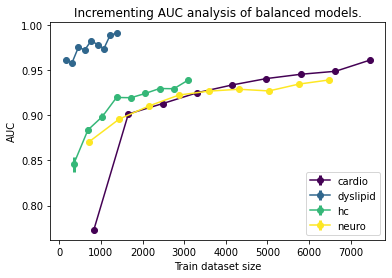

In [17]:
categories = incrementing_auc_df_balanced['panel'].unique()
pallette = viridis(categories.size)
colormap = dict(zip(categories, pallette))
incrementing_auc_df_balanced['color'] = incrementing_auc_df_balanced['panel'].map(colormap)
for panel in incrementing_auc_df_balanced['panel'].unique():
    subset = incrementing_auc_df_balanced[incrementing_auc_df_balanced['panel'] == panel]
    plt.errorbar(
        x=subset['train_size'],
        y=subset['auc'],
        yerr=subset['stdev'],
        c=subset['color'].unique()[0],
        label=panel,
        fmt='o',
        capsize=0,
        elinewidth=3,
        ls='-'
    )
plt.legend()
plt.xlabel('Train dataset size')
plt.ylabel('AUC')
plt.title('Incrementing AUC analysis of balanced models.')
plt.show()

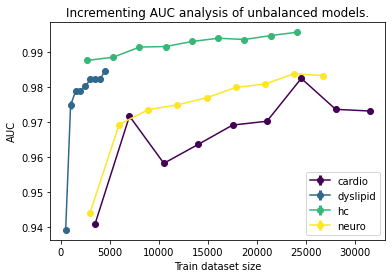

In [18]:
categories = incrementing_auc_df_unbalanced['panel'].unique()
pallette = viridis(categories.size)
colormap = dict(zip(categories, pallette))
incrementing_auc_df_unbalanced['color'] = incrementing_auc_df_unbalanced['panel'].map(colormap)
for panel in incrementing_auc_df_unbalanced['panel'].unique():
    subset = incrementing_auc_df_unbalanced[incrementing_auc_df_unbalanced['panel'] == panel]
    plt.errorbar(
        x=subset['train_size'],
        y=subset['auc'],
        yerr=subset['stdev'],
        c=subset['color'].unique()[0],
        label=panel,
        fmt='o',
        capsize=0,
        elinewidth=3,
        ls='-'
    )
plt.legend()
plt.xlabel('Train dataset size')
plt.ylabel('AUC')
plt.title('Incrementing AUC analysis of unbalanced models.')
plt.show()

# Model on best performing panel, prepartation
[Index](#Index)

In [13]:
ek = genepanels['Erfelijke Kanker']
ek

{'Borstkanker': ['ATM', 'BRCA1', 'BRCA2', 'CHEK2', 'PALB2'],
 'Borstkanker & Li Fraumeni syndroom': ['ATM',
  'BRCA1',
  'BRCA2',
  'CHEK2',
  'PALB2',
  'TP53'],
 'Darmkanker': ['EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'MUTYH',
  'PMS2',
  'POLD1',
  'POLE'],
 'Darmpoliepen': ['APC',
  'AXIN2',
  'BMPR1A',
  'ENG',
  'MSH3',
  'MUTYH',
  'NTHL1',
  'POLD1',
  'POLE',
  'PTEN',
  'RNF43',
  'SMAD4',
  'SMAD4',
  'STK11'],
 'Eierstokkanker': ['BRCA1',
  'BRCA2',
  'BRIP1',
  'EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'PMS2',
  'RAD51C',
  'RAD51D'],
 'Endocrinologie-feochromocytomen': ['FH',
  'MAX',
  'MDH2',
  'NF1',
  'RET',
  'SDHA',
  'SDHAF2',
  'SDHB',
  'SDHC',
  'SDHD',
  'TMEM127',
  'VHL'],
 'Endocrinologie-NET': ['AIP',
  'CDKN1A',
  'CDKN1B',
  'CDKN2B',
  'CDKN2C',
  'MEN1',
  'NF1',
  'PRKAR1A'],
 'Huidkanker': ['ACD',
  'ACTRT1',
  'BAP1',
  'CDK4',
  'CDKN2A',
  'ERCC2',
  'MITF',
  'POLH',
  'POT1',
  'PTCH1',
  'PTCH2',
  'SUFU',
  'TERF2IP',
  'TERT'],
 'Kinderonco-med

In [14]:
ek_genes = []
for key, values in ek.items():
    for value in values:
        if value not in ek_genes:
            ek_genes.append(value)
len(ek_genes)

87

In [15]:
ek_subset = train.loc[train['GeneName'].isin(ek_genes)]
ek_subset

NameError: name 'train' is not defined

In [ ]:
ek_subset['label'].value_counts()

# Barplot of type of variants for each panel
[Index](#Index)

In [ ]:
variants = pd.read_csv('/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/datafiles/train.txt.gz', compression='gzip', sep='\t', low_memory=False)
variants

In [ ]:
ax = variants['Consequence'].value_counts().plot(kind='bar')
ax.set_title('Type of SNV over the entire training dataset.')
ax.set_ylabel('Count')
ax.set_xlabel('Consequence')

In [ ]:
# Reduce the information to just panels.

panels = {}
for panel in genepanels.keys():
    panels[panel] = []
    disease_panel = genepanels[panel]
    if isinstance(disease_panel, dict):
        for disease, genes in disease_panel.items():
            for gene in genes:
                if gene not in panels[panel]:
                    panels[panel].append(gene)

In [ ]:
for panel, genes in panels.items():
    title = f'Type of SNV over the entire training dataset, panel: {panel}'
    subset = variants[variants['GeneName'].isin(genes)]
    data = subset['Consequence'].value_counts()
    ax = data.plot.bar(x='index', y='Consequence',
                      colormap='viridis',
                      title=title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Panel')
    fig = plt.Figure()
    fig.axes.append(ax)
    plt.show()